## Table of Contents
- [Introduction](#Introduction)
- [Exploratory Data Analysis (EDA)](#EDA)
- [Feature Engineering](#feature-engineering)
- [Target variable](#target-variable)
- [Data Split](#data-split)
- [Modeling](#modeling)
- [Simulation](#simulation)
- [HP Optimization](#hp_optimization)
- [Answers](#answers)

## Introduction

The following ntb is developed for data scientist.

The problem of having sequence-to-one data can be solved differently, for example:
- by capturing the process dynamics and attributes by some statistics (rolling, lags etc.)
- by using sequence-to-one models like LSTM and RNNs.

I will start with the first approach, which I treat as regression problem.

In [41]:
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%config Completer.use_jedi = False

In [80]:
TEMP_THRESHOLD = 1680  # Desired temp threshold.
TEMP_BAND = 10  # Temp band which defines the band of ±10 C where `end_t` is considered to be reached.
DELAY = 5  # Measurement delay in sec.
COST_BELOW = 100  # eur per restart
COST_ABOVE = 10  # eur per each 10 degrees
ASYM_METRIC_ELAPSED = 500  # Elapsed time used to start to penalize model.

## EDA

Let me have a look on the data.

In [3]:
data = pd.read_csv("../data/input.csv", parse_dates=["datetime"])
print(data.shape)
print(data.dtypes)
data.head(2)

(108987, 4)
heatid               int64
datetime    datetime64[ns]
end_t              float64
gas1               float64
dtype: object


,heatid,datetime,end_t,gas1
0,16523,2023-01-01 01:00:00,NaN,9.847
1,16523,2023-01-01 01:00:05,NaN,9.850


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108987 entries, 0 to 108986
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   heatid    108987 non-null  int64         
 1   datetime  108987 non-null  datetime64[ns]
 2   end_t     690 non-null     float64       
 3   gas1      108987 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 3.3 MB


In [5]:
data.describe()

,heatid,datetime,end_t,gas1
count,108987.000000,108987,690.000000,108987.000000
mean,16867.321745,2023-01-15 23:56:10.013258496,1704.950725,9.879033
min,16523.000000,2023-01-01 01:00:00,1545.000000,0.000000
25%,16695.000000,2023-01-08 12:07:17.500000,1645.250000,10.091000
50%,16868.000000,2023-01-16 01:04:35,1706.000000,10.341000
75%,17039.000000,2023-01-23 11:12:42.500000,1758.000000,10.555000
max,17212.000000,2023-01-30 23:13:55,1918.000000,10.905000
std,199.161575,NaN,70.649201,2.154289


The data is given for app. 1 month and consists of 690 processes with main statistics provided in the table above.

Let's check the distribution of the data.

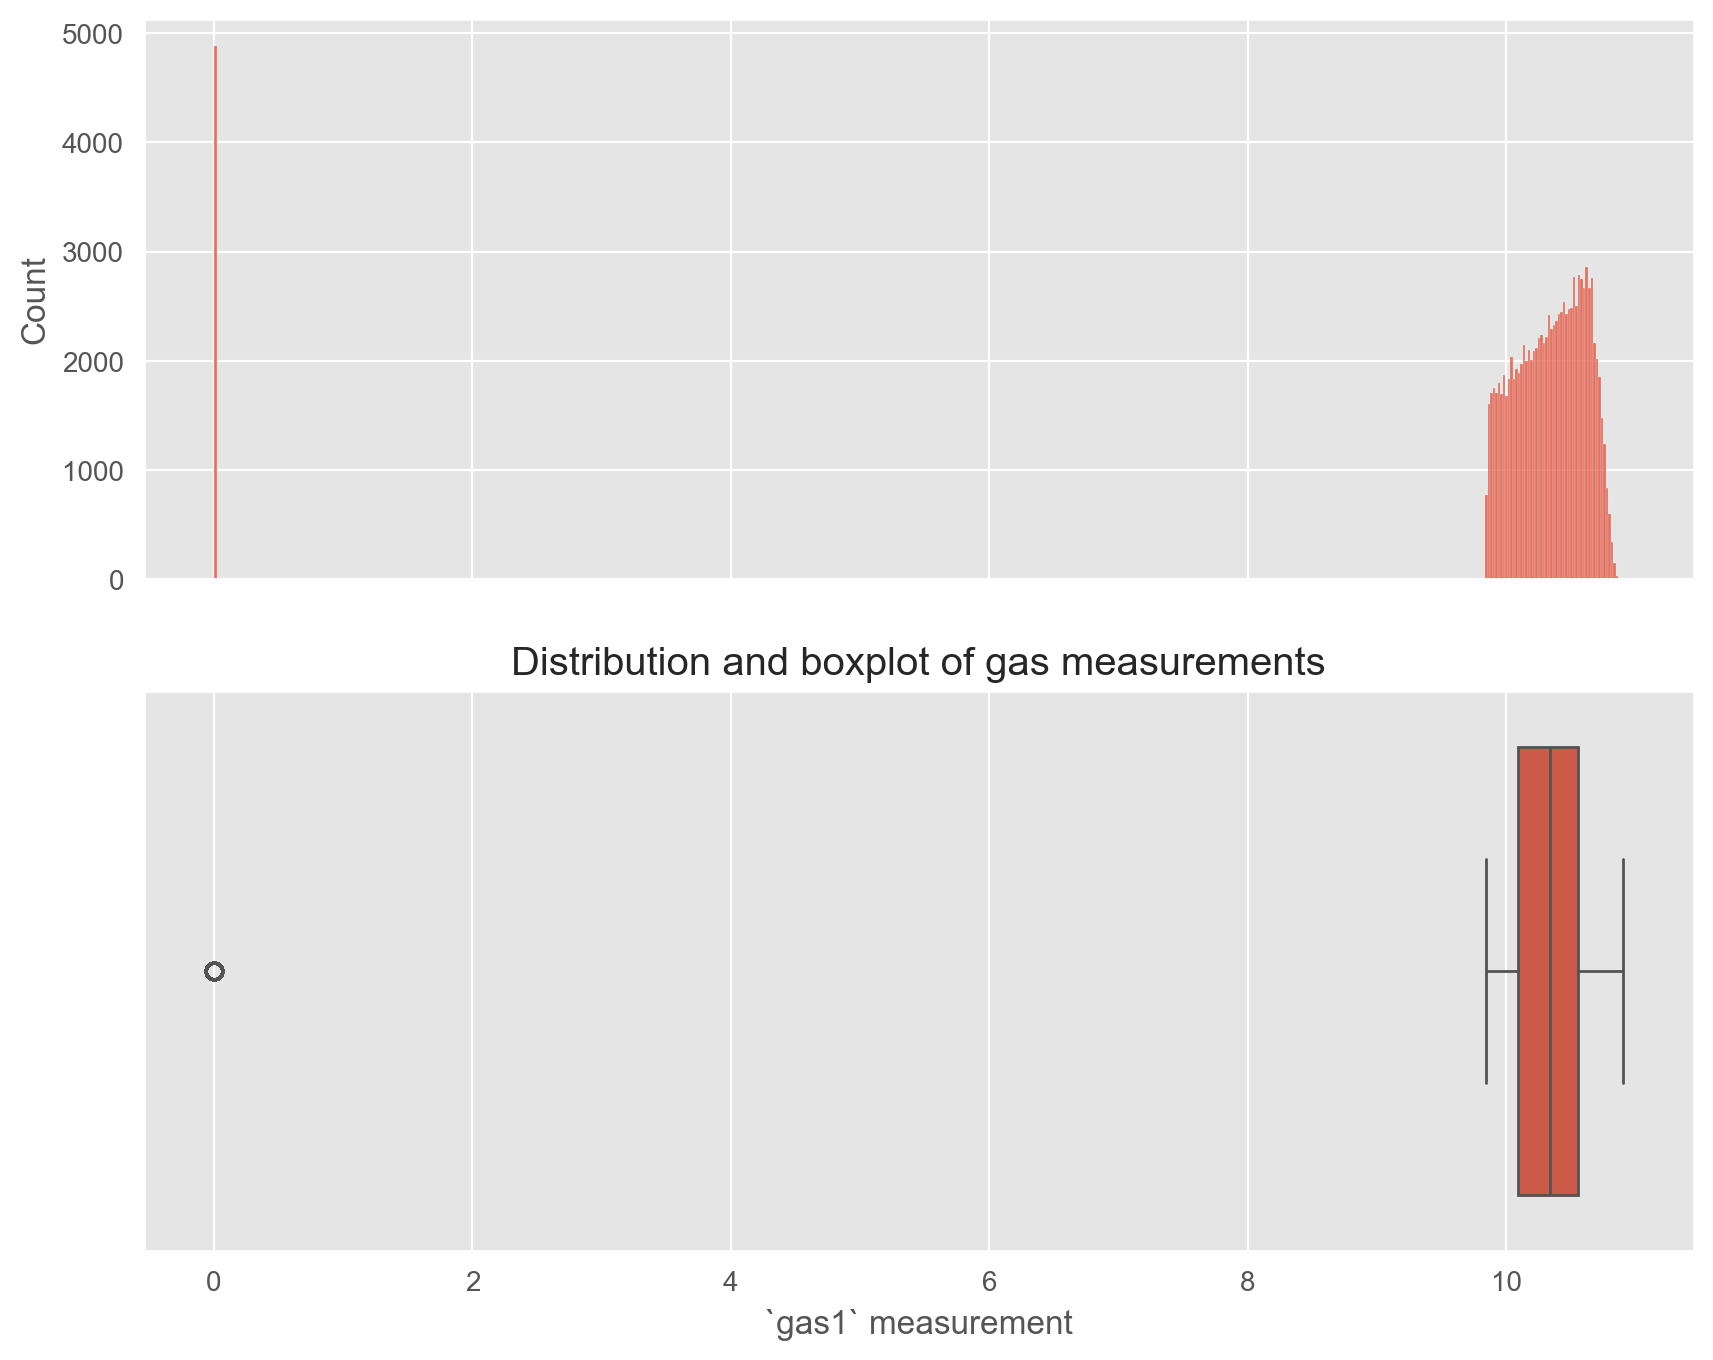

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.title("Distribution and boxplot of gas measurements")
sns.histplot(data["gas1"], ax=axes[0])
sns.boxplot(x=data["gas1"], ax=axes[1])
plt.xlabel("`gas1` measurement")
plt.show();

There are some outliers which are most probably comes from measurement signal noice/error.
Let see how many outliers there are and think what I'd better do with them.

In [7]:
data_outliers = data.loc[
                (data["gas1"] >= (data["gas1"].mean() + 3 * data["gas1"].std()))
                |
                (data["gas1"] <= (data["gas1"].mean() - 3 * data["gas1"].std()))
, :]
data_outliers.shape

(4882, 4)

Let me check how some processes look like.

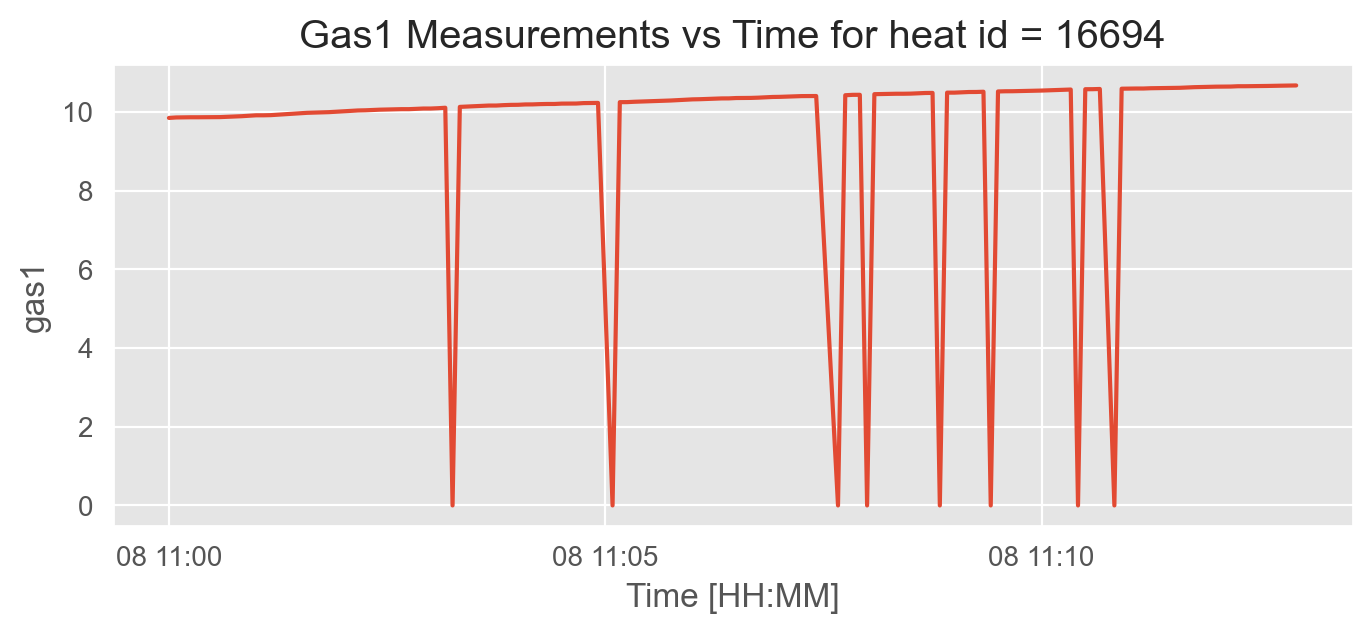

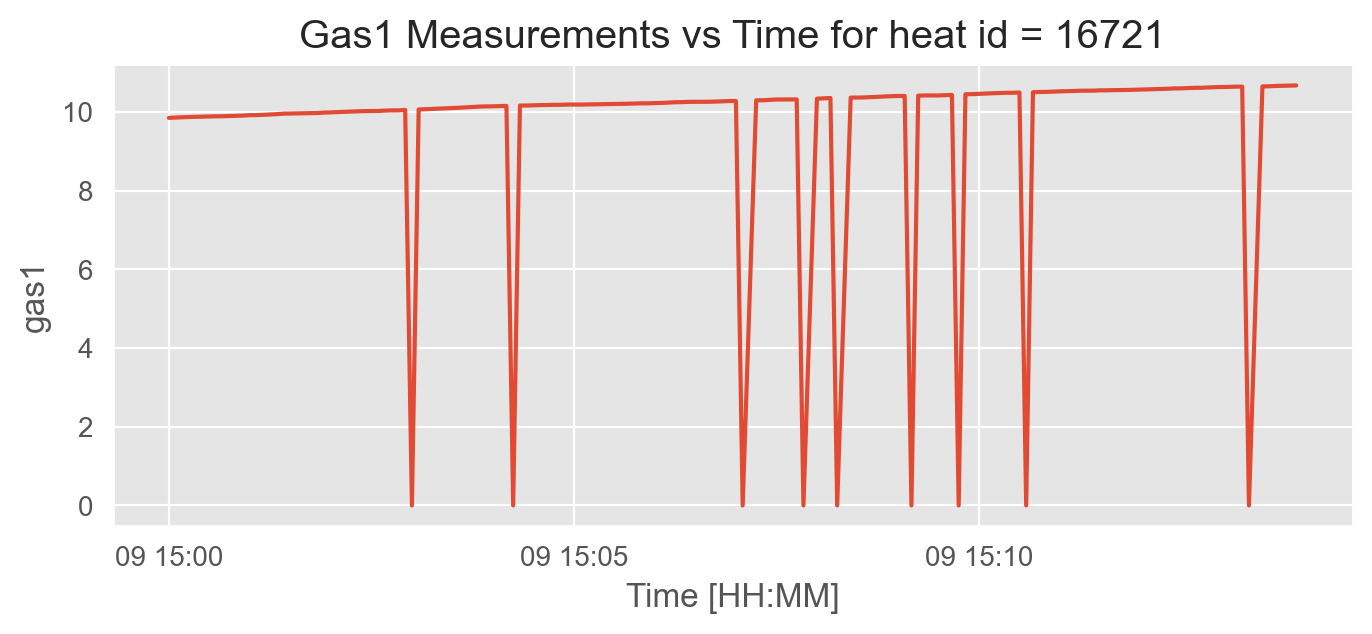

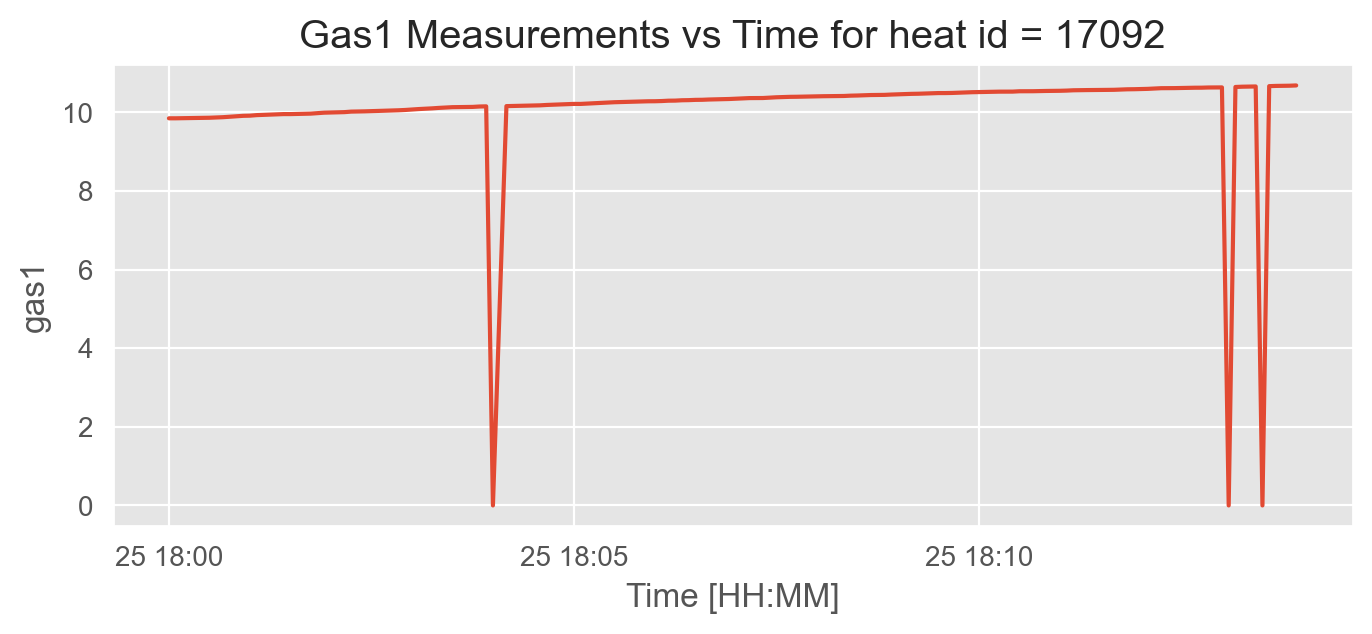

In [8]:
ids = pd.Series(data["heatid"].unique())
for _id in ids.sample(3, random_state=2):
    heat_id_slice = data.loc[data["heatid"] == _id]
    plt.figure(figsize=(8, 3))
    plt.plot(heat_id_slice["datetime"], heat_id_slice["gas1"])
    plt.title(f"Gas1 Measurements vs Time for heat id = {_id}")
    plt.xlabel("Time [HH:MM]")
    plt.ylabel("gas1")
    plt.show()

Now it's clearly seen that the values near zero come from measurement device errors.
Thus, I will use simple linear interpolation to infer these missing near zero values per process.
I will incorporate this step into further data preparation pipeline. But for now, let us continue EDA.

In [9]:
def interpolate_zero_values(df: pd.DataFrame, col: str = "gas1", method: str = "linear") -> pd.DataFrame:
    """Interpolate zero values in the `col` column of the `df` dataframe."""
    df = df.copy()
    df.loc[df[col] == 0, col] = np.nan
    df[col] = df[col].interpolate(method=method)
    return df

In [10]:
interpolated_data = interpolate_zero_values(data)

Let's check how the `gas1` variable looks like after interpolation.
Here I interactively change `n_samples` and `random state` to vizualize different processes.

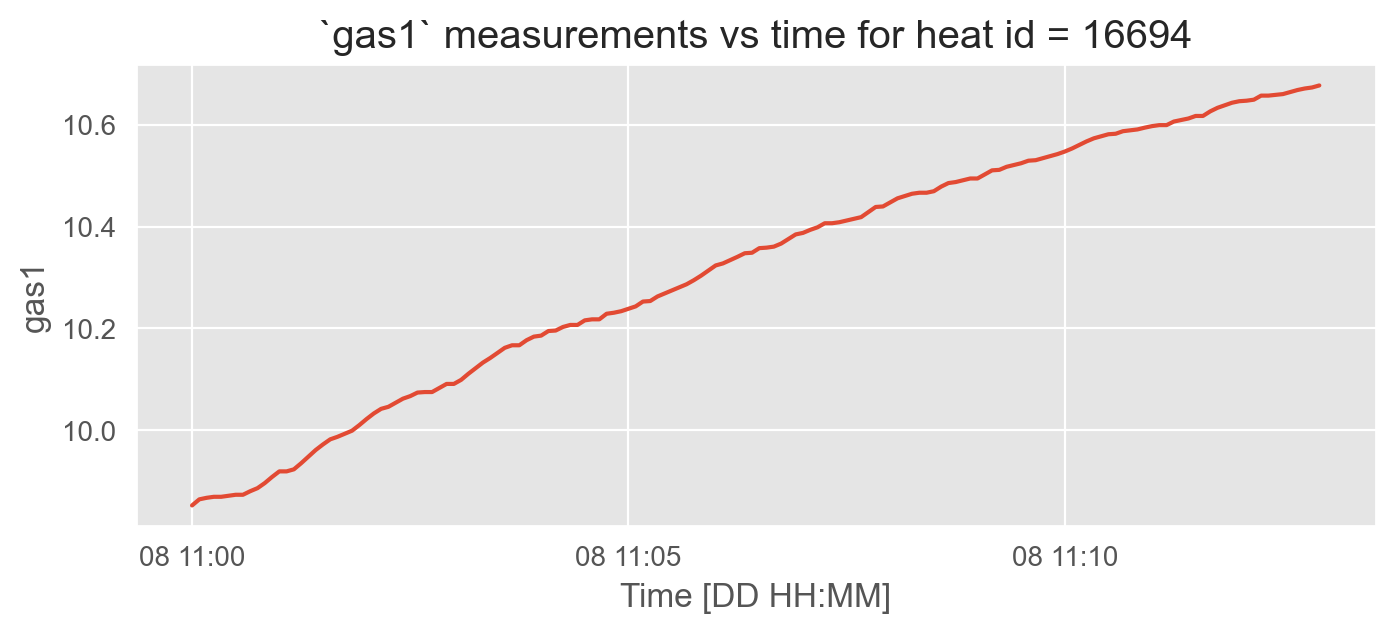

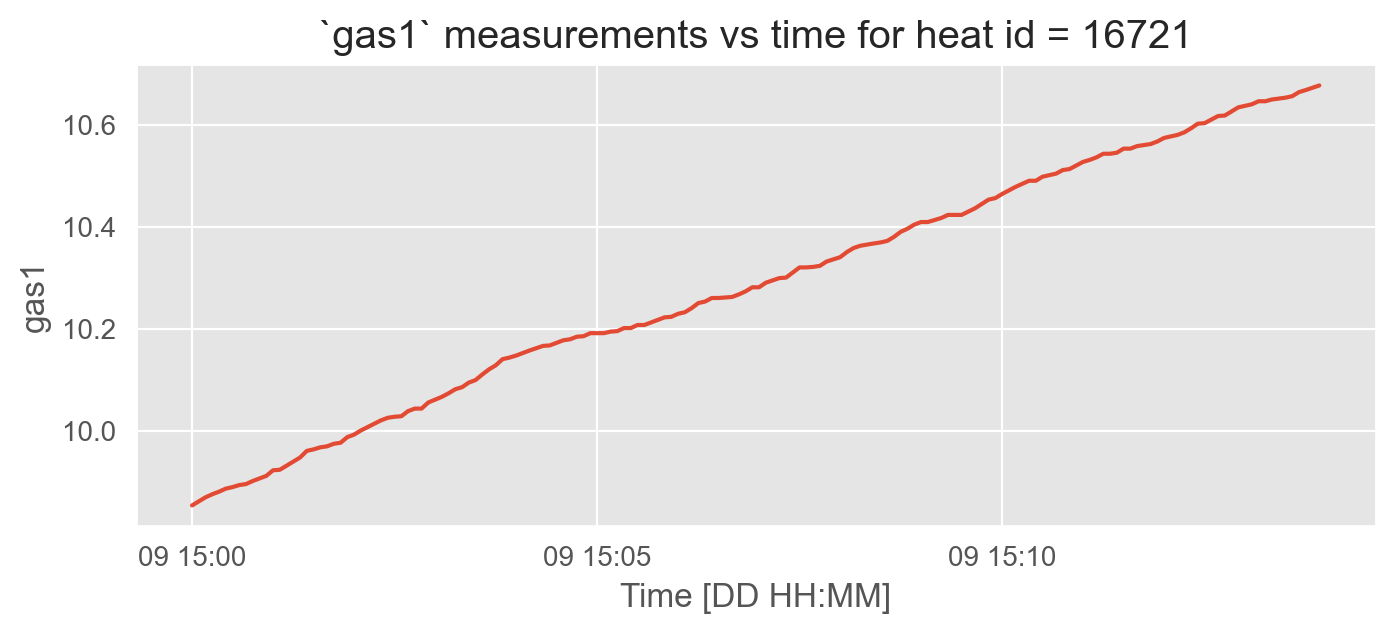

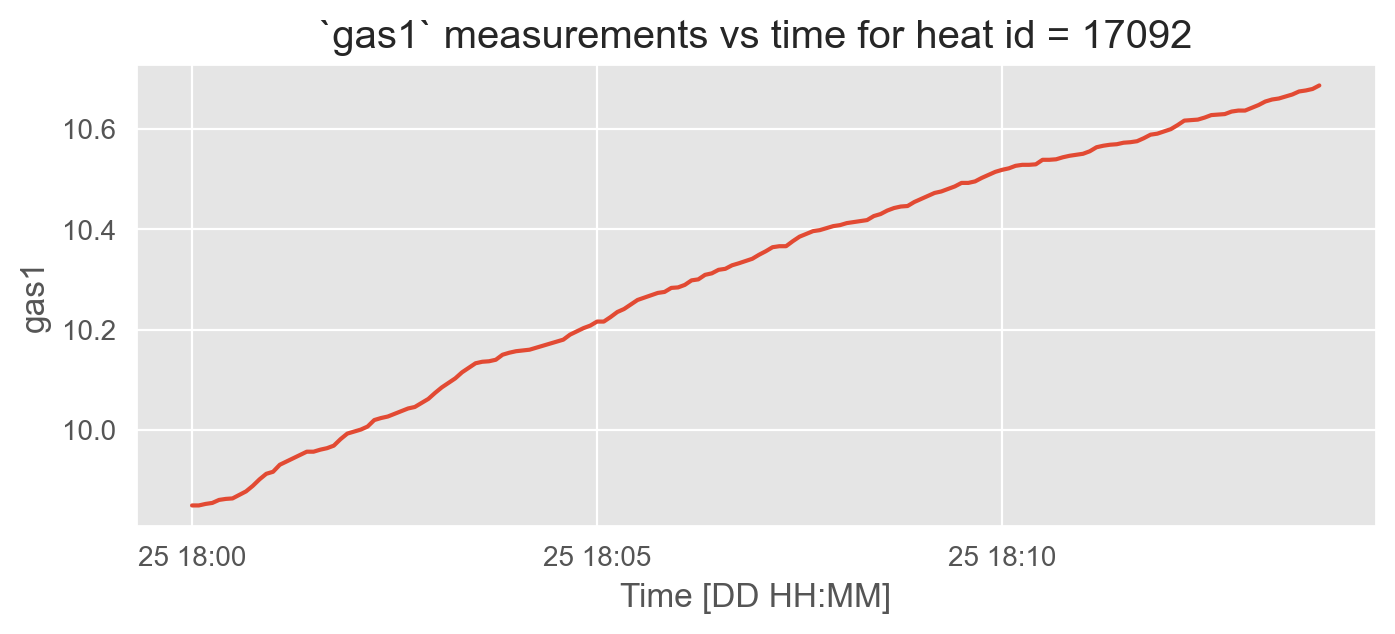

In [11]:
n_samples = 3
rnd_state = 2
ids = pd.Series(interpolated_data["heatid"].unique())
for _id in ids.sample(n_samples, random_state=rnd_state):
    heat_id_slice = interpolated_data.loc[interpolated_data["heatid"] == _id]
    plt.figure(figsize=(8, 3))
    plt.plot(heat_id_slice["datetime"], heat_id_slice["gas1"])
    plt.title(f"`gas1` measurements vs time for heat id = {_id}")
    plt.xlabel("Time [DD HH:MM]")
    plt.ylabel("gas1")
    plt.show()

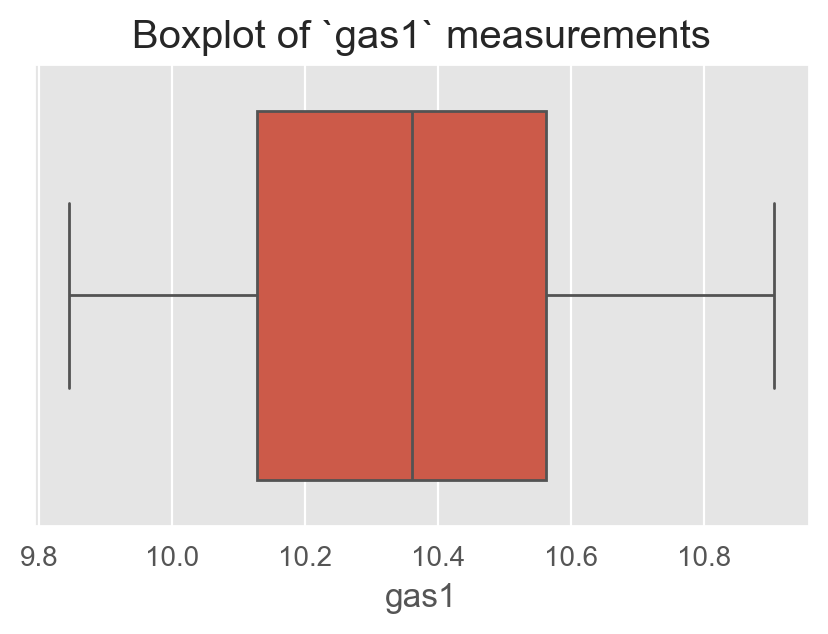

In [12]:
plt.figure(figsize=(5, 3))
sns.boxplot(x=interpolated_data["gas1"])
plt.title("Boxplot of `gas1` measurements")
plt.show()

Now `gas1` variable looks ready for further modeling.

#### Delay shift in the `gas1` measurements
For now, I will perform a simple time shift of the `datetime` variable,
so that the model will learn corrected time stamps.
And will think how to do this properly for real time inference later on.

In [13]:
shifted_data = interpolated_data.copy()
shifted_data["datetime"] = interpolated_data["datetime"] - pd.Timedelta(seconds=DELAY)

Let me check how the target variable looks like, here again I interactively check several processes.
Another way of making interactive plots could be [plotly](https://plotly.com/) or similar package, though plots are quite heavy and I don't want to overload git with them without a real need.

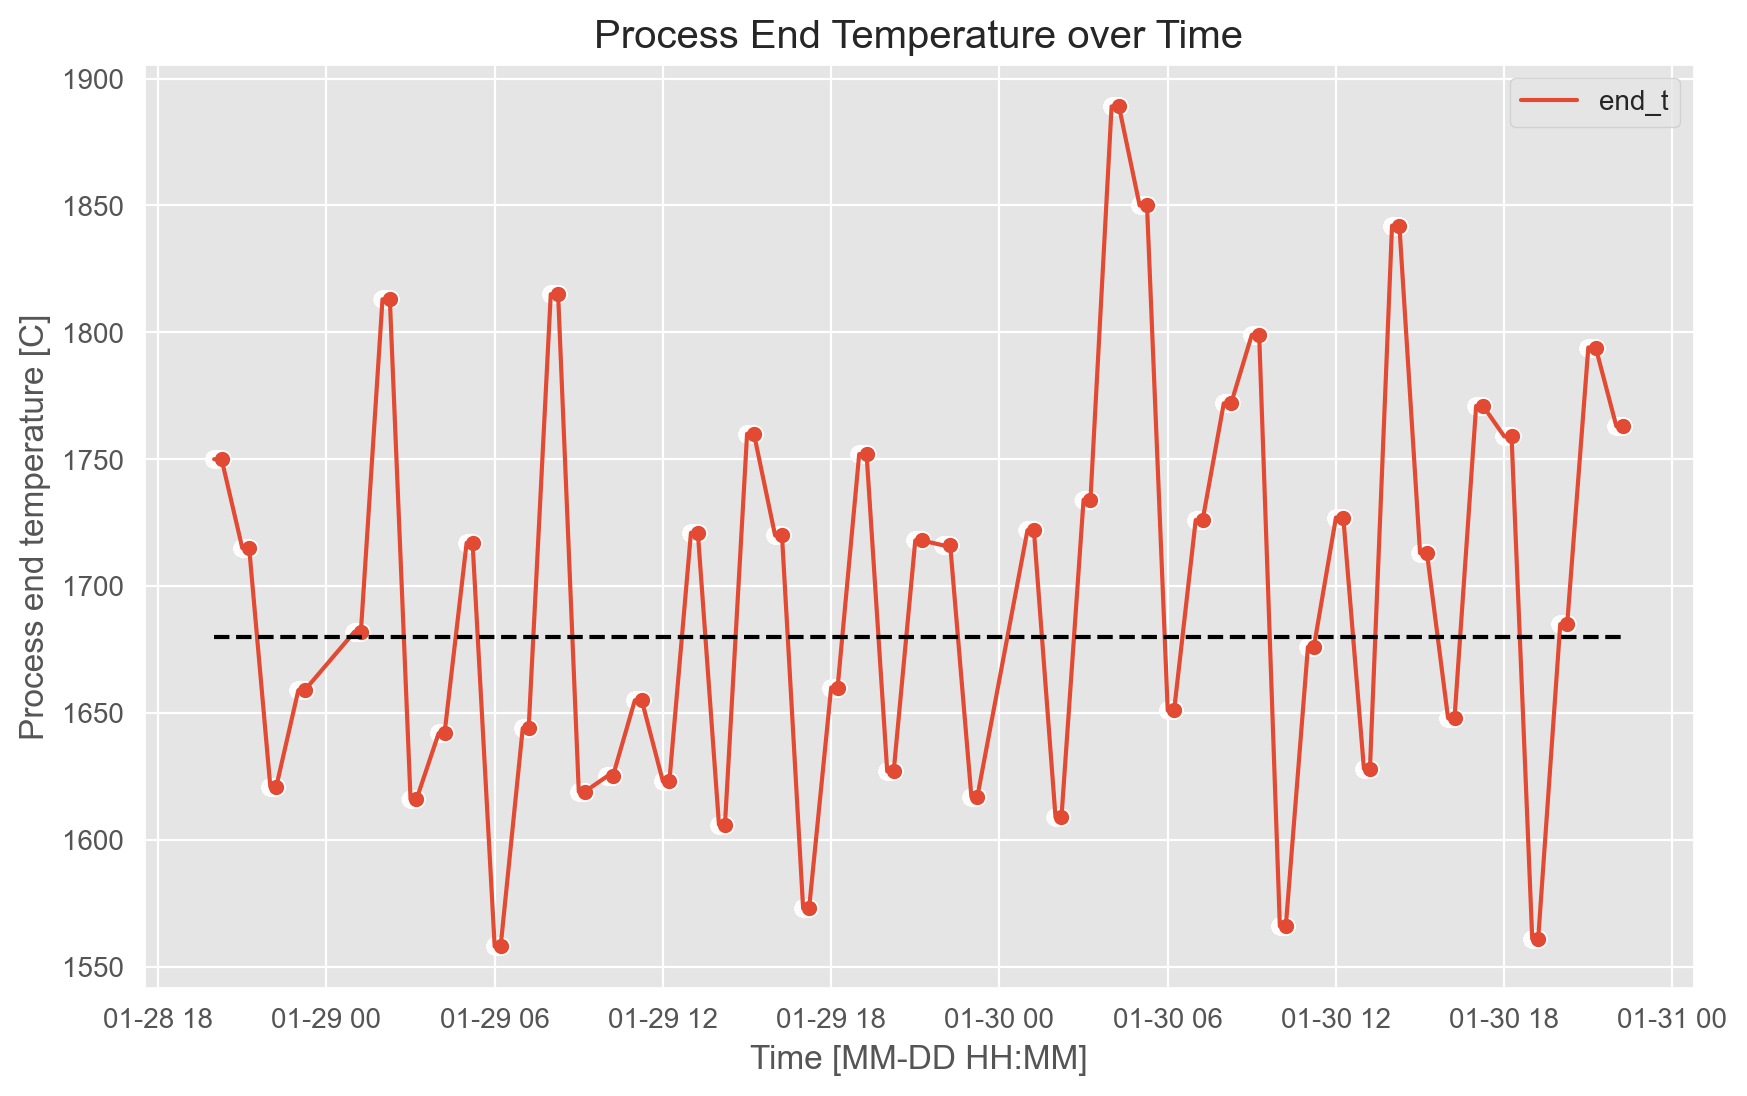

In [14]:
n_proc_start, n_proc_stop = -50, -1
plt.figure(figsize=(10, 6))
heatids = shifted_data.heatid.unique()
plot_df = shifted_data.loc[shifted_data["heatid"].isin(heatids[n_proc_start:n_proc_stop]), :]
plot_df.loc[:, ["end_t"]] = plot_df.groupby("heatid")["end_t"].bfill()
sns.lineplot(data=plot_df, x="datetime", y="end_t", label="end_t")
sns.scatterplot(data=plot_df, x="datetime", y="end_t", markers="o")
plt.hlines(TEMP_THRESHOLD, plot_df["datetime"].min(), plot_df["datetime"].max(), linestyles="--", colors="k")
plt.title("Process End Temperature over Time")
plt.xlabel("Time [MM-DD HH:MM]")
plt.ylabel("Process end temperature [C]")
plt.show()

In [15]:
n_lower = shifted_data.loc[shifted_data["end_t"] < TEMP_THRESHOLD, :].shape[0]
n_higher = shifted_data.loc[shifted_data["end_t"] > TEMP_THRESHOLD, :].shape[0]
print(f"Number of processes with end_t < {TEMP_THRESHOLD} = {n_lower}")
print(f"Number of processes with end_t > {TEMP_THRESHOLD} = {n_higher}")

Number of processes with end_t < 1680 = 268
Number of processes with end_t > 1680 = 418


It can be seen that `end_t` is oscillating around `1680` C temperature threshold, indicating the operator tries indeed to meet `1680` value.
As well as it's clearly seen that the cost of early stopping is higher than stopping the process at higher temperatures.

I will use previous process(es) `end_t` values as feature as the current `end_t` depends on the previous processes' temperatures.

Let me check some further basic statistics and properties of the processes that is why I will aggregate data at the process level.
I also use `TEMP_BAND` to define the band within which `end_t` is considered to be reached. This is just the gut feeling and mostly for exploration and I might change the approach later on.

In [16]:
n_prev = 5
aggregated_stats = shifted_data.groupby("heatid")["gas1"].agg(
    max_gas1="max",
    min_gas1="min",
    std_gas1="std",
    mean_gas1="mean",
    first_gas1="first",
    last_gas1="last",
    diff_gas1="diff",
)
aggregated_stats["mean_diff_gas1"] = shifted_data.groupby("heatid")["gas1"].diff().groupby(
    shifted_data["heatid"]).mean()
aggregated_temp = shifted_data.groupby("heatid")["end_t"].agg(end_t="last")
time_stats = shifted_data.groupby("heatid")["datetime"].agg(
    max_time="max",
    min_time="min"
)
time_stats["elapsed"] = (time_stats["max_time"] - time_stats["min_time"]).dt.total_seconds()
time_stats["start_hour"] = time_stats["min_time"].dt.hour
time_stats["end_hour"] = time_stats["max_time"].dt.hour
time_stats["day_of_month"] = time_stats["min_time"].dt.day
aggregated_stats = time_stats.loc[:, :].merge(aggregated_stats, left_index=True, right_index=True)
aggregated_stats = aggregated_stats.merge(
    aggregated_temp.loc[:, [c for c in aggregated_temp if c.startswith("prev_end_t")]], left_index=True,
    right_index=True)
aggregated_stats = aggregated_stats.merge(shifted_data.groupby("heatid")["end_t"].agg("first"), left_index=True,
                                          right_index=True)
aggregated_stats["end_t_diff"] = aggregated_stats["end_t"] - TEMP_THRESHOLD
# Label end_t being withing the band.
aggregated_stats["status"] = np.where(
    aggregated_stats["end_t"] > (TEMP_THRESHOLD + TEMP_BAND), "higher",
    np.where(aggregated_stats["end_t"] < (TEMP_THRESHOLD - TEMP_BAND), "lower", "equal")
)
aggregated_stats = aggregated_stats.merge(
    shifted_data.groupby("heatid")["heatid"].agg("first"), left_index=True, right_index=True
)
aggregated_stats["heatid"] = shifted_data.groupby("heatid")["heatid"].first()
# Add end_t and gas1 values from the previous processes.
for i in range(1, n_prev + 1):
    aggregated_temp[f"previous_end_t_{i}"] = aggregated_temp["end_t"].shift(i)
for i in range(1, n_prev + 1):
    aggregated_stats[f"previous_first_gas_{i}"] = aggregated_stats["first_gas1"].shift(i)
    aggregated_stats[f"previous_last_gas_{i}"] = aggregated_stats["last_gas1"].shift(i)
aggregated_stats.sample(4)

,max_time,min_time,elapsed,start_hour,end_hour,day_of_month,max_gas1,min_gas1,std_gas1,mean_gas1,...,previous_first_gas_1,previous_last_gas_1,previous_first_gas_2,previous_last_gas_2,previous_first_gas_3,previous_last_gas_3,previous_first_gas_4,previous_last_gas_4,previous_first_gas_5,previous_last_gas_5
16981,2023-01-20 22:12:50,2023-01-20 21:59:55,775.0,21,22,20,10.651,9.856,0.226693,10.281839,...,9.850,10.733,9.849,10.797,9.8470,10.761,10.3365,10.757,9.847,10.803
17098,2023-01-26 01:12:50,2023-01-26 00:59:55,775.0,0,1,26,10.637,9.845,0.227208,10.282406,...,9.860,10.706,9.847,10.631,10.3405,10.680,9.8500,10.828,9.849,10.733
17054,2023-01-24 03:12:50,2023-01-24 02:59:55,775.0,2,3,24,10.667,9.860,0.229410,10.311295,...,9.845,10.667,9.845,10.819,9.8530,10.789,9.8500,10.775,9.858,10.817
16616,2023-01-05 02:14:50,2023-01-05 01:59:55,895.0,1,2,5,10.766,9.853,0.264705,10.332750,...,9.873,10.717,9.860,10.811,9.8580,10.673,9.8490,10.679,9.847,10.784


Let me visually check whether there are some dependencies in data, this might help to check if the model weights align with the following findings.

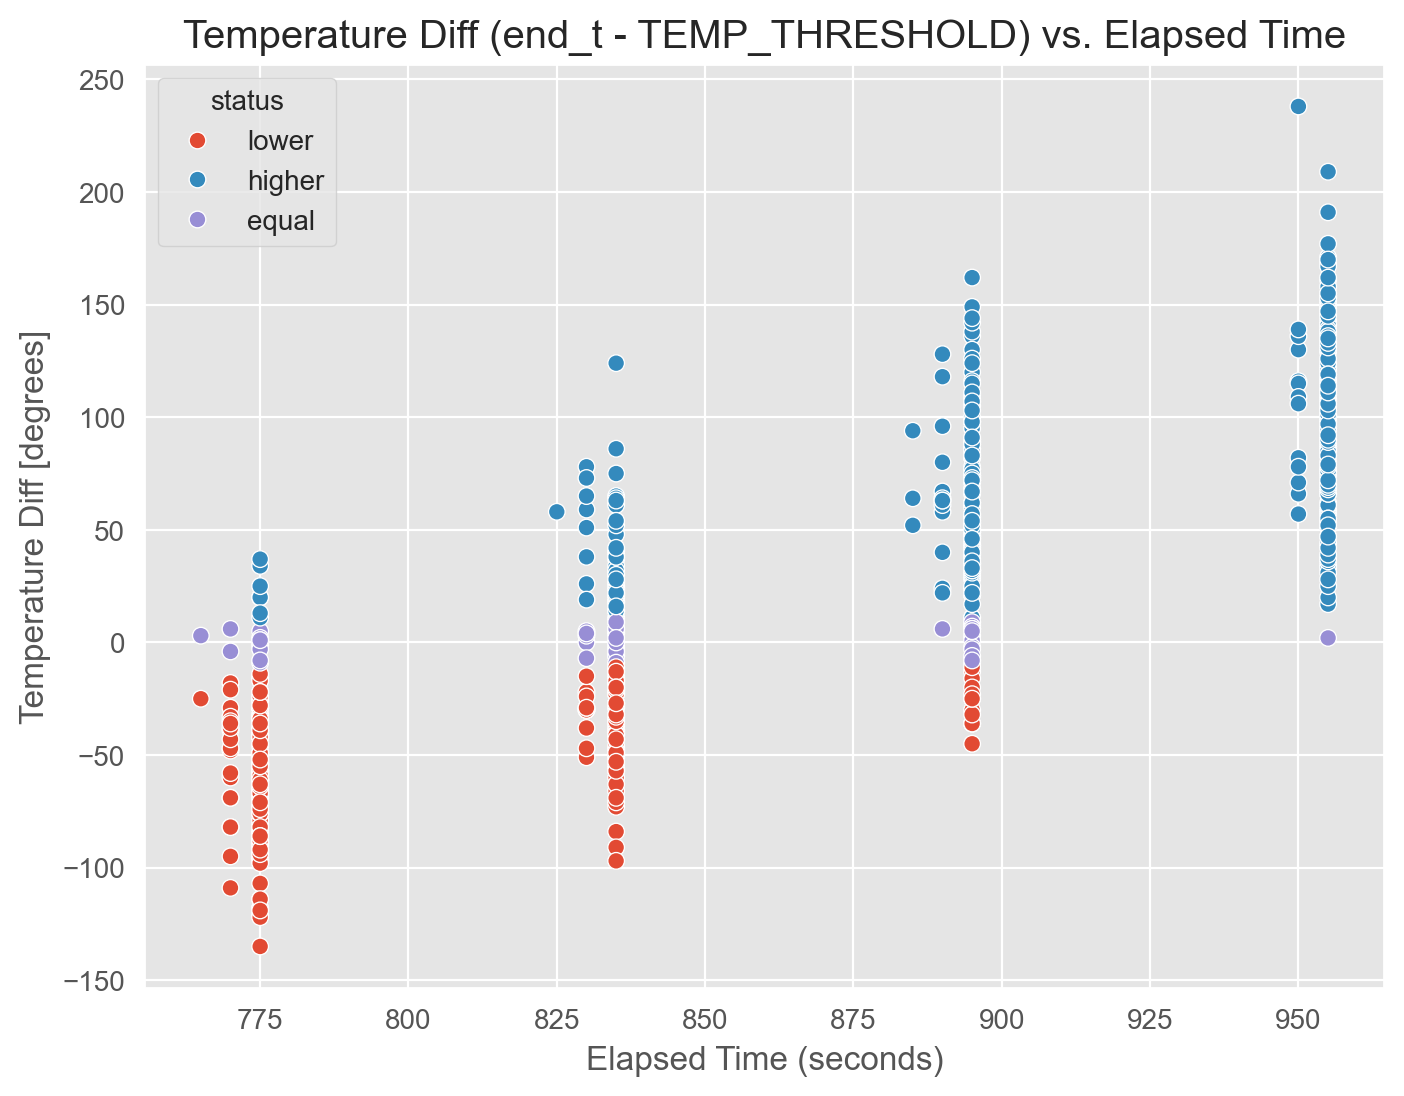

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="elapsed", y="end_t_diff", data=aggregated_stats, hue="status")
plt.title("End Temperature vs. Elapsed Time")
plt.title("Temperature Diff (end_t - TEMP_THRESHOLD) vs. Elapsed Time")
plt.xlabel("Elapsed Time (seconds)")
plt.ylabel("Temperature Diff [degrees]")
plt.show();

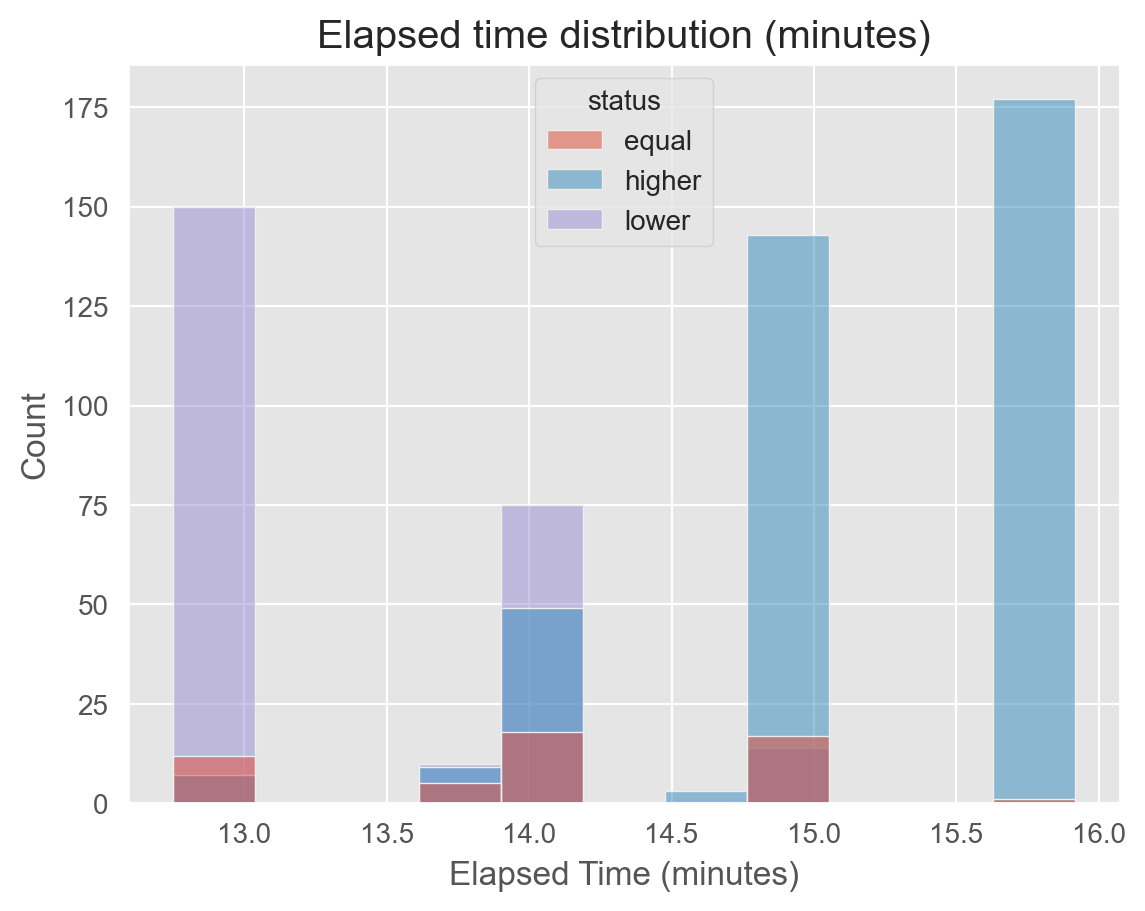

In [18]:
plot_df = aggregated_stats.copy()
plot_df["elapsed"] = plot_df["elapsed"].apply(lambda x: x / 60)
sns.histplot(data=plot_df, x="elapsed", hue="status", hue_order=["equal", "higher", "lower"])
plt.title(f"Elapsed time distribution (minutes)")
plt.xlabel("Elapsed Time (minutes)");

From the graph above tt seems there are only 4 major clusters of process elapsed time. This could be due to 4 major operation modes when the steel converter can be stopped.
I would clarify this with the customer/operator first of all.
But for now I will assume 4 major operation modes, which should make it easier to recommend operator to stop at real-time scenario as it makes a decision to be discrete.
Moreover, the problem can be also formulated as multi-class classification.
I'll continue with EDA.

In [19]:
bins = [-np.inf, -50, -20, -10, 0, 10, 20, 50, np.inf]
labels = [
    "t <= -50",
    "-50 < t <= -20",
    "-20 < t <= -10",
    "-10 < t <= 0",
    "0 < t <= 10",
    "10 < t <= 20",
    "20 < t <= 50",
    "50 < t",
]
aggregated_stats["temp_bin"] = pd.cut(aggregated_stats["end_t_diff"], bins=bins, labels=labels)
aggregated_stats["temp_bin"].value_counts().sort_index()

temp_bin
t <= -50          119
-50 < t <= -20    106
-20 < t <= -10     24
-10 < t <= 0       23
0 < t <= 10        30
10 < t <= 20       20
20 < t <= 50      102
50 < t            266
Name: count, dtype: int64

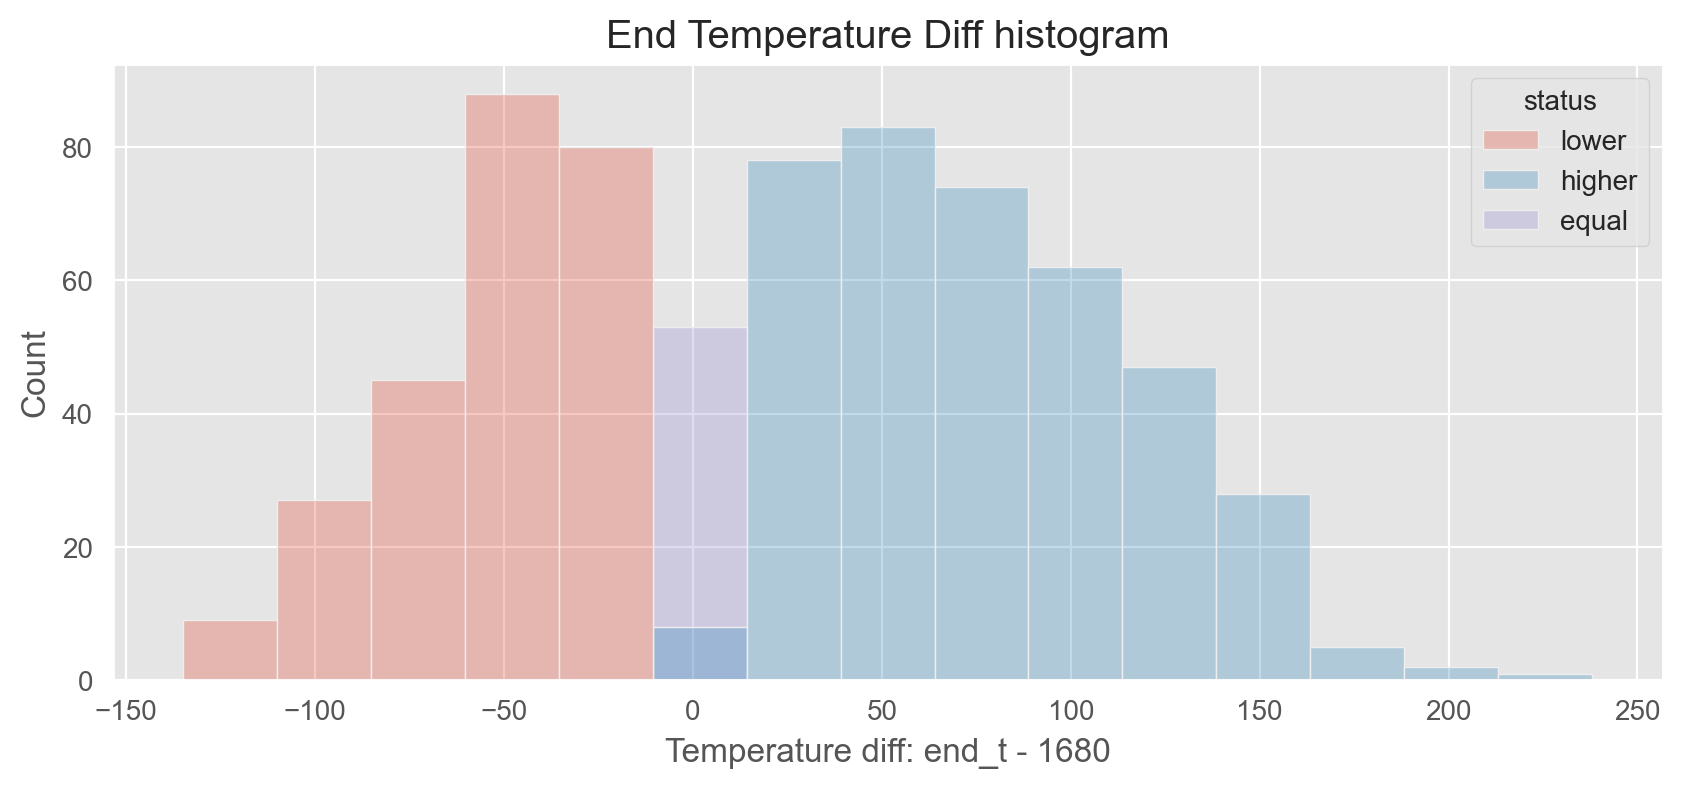

In [20]:
plt.figure(figsize=(10, 4))
sns.histplot(data=aggregated_stats, x="end_t_diff", hue="status", alpha=0.3)
plt.title("End Temperature Diff histogram")
plt.xlabel(f"Temperature diff: end_t - {TEMP_THRESHOLD}")
plt.show();

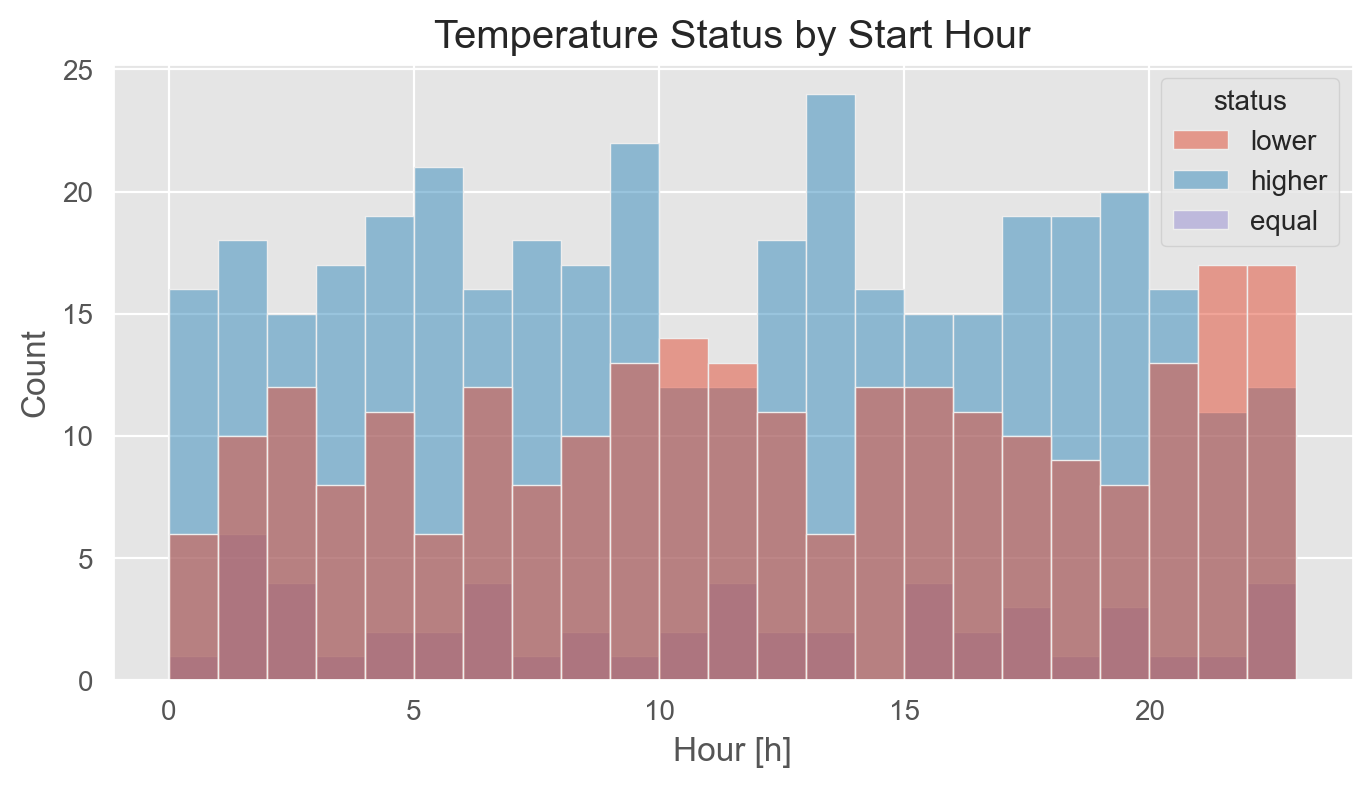

In [21]:
plt.figure(figsize=(8, 4))
sns.histplot(x="start_hour", hue="status", data=aggregated_stats, bins=23)
plt.title("Temperature Status by Start Hour")
plt.xlabel("Hour [h]")
plt.ylabel("Count")
plt.show()

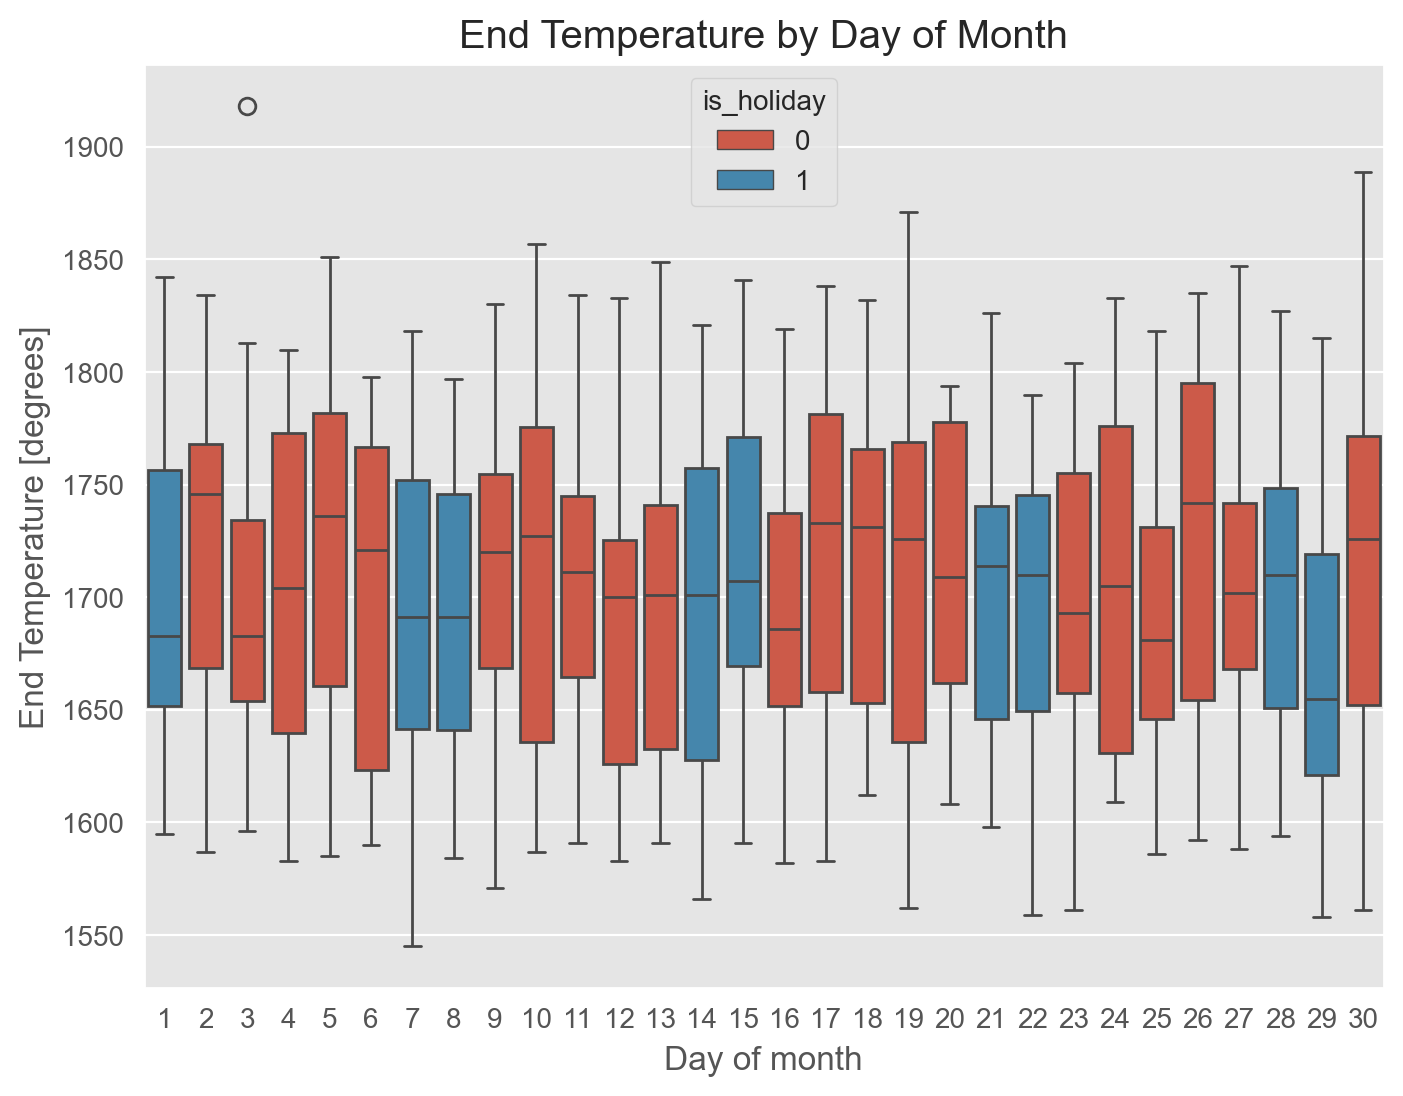

In [22]:
plt.figure(figsize=(8, 6))
aggregated_stats["is_holiday"] = aggregated_stats.apply(
    lambda row: 1 if row["min_time"].day_of_week in [5, 6] else 0, axis=1
)
sns.boxplot(x="day_of_month", y="end_t", hue="is_holiday", data=aggregated_stats)
plt.title("End Temperature by Day of Month")
plt.xlabel("Day of month")
plt.ylabel("End Temperature [degrees]")
plt.show()

So far I don't see correlations between target and datetime features.

Average elapsed time for equal processes: 842 seconds.


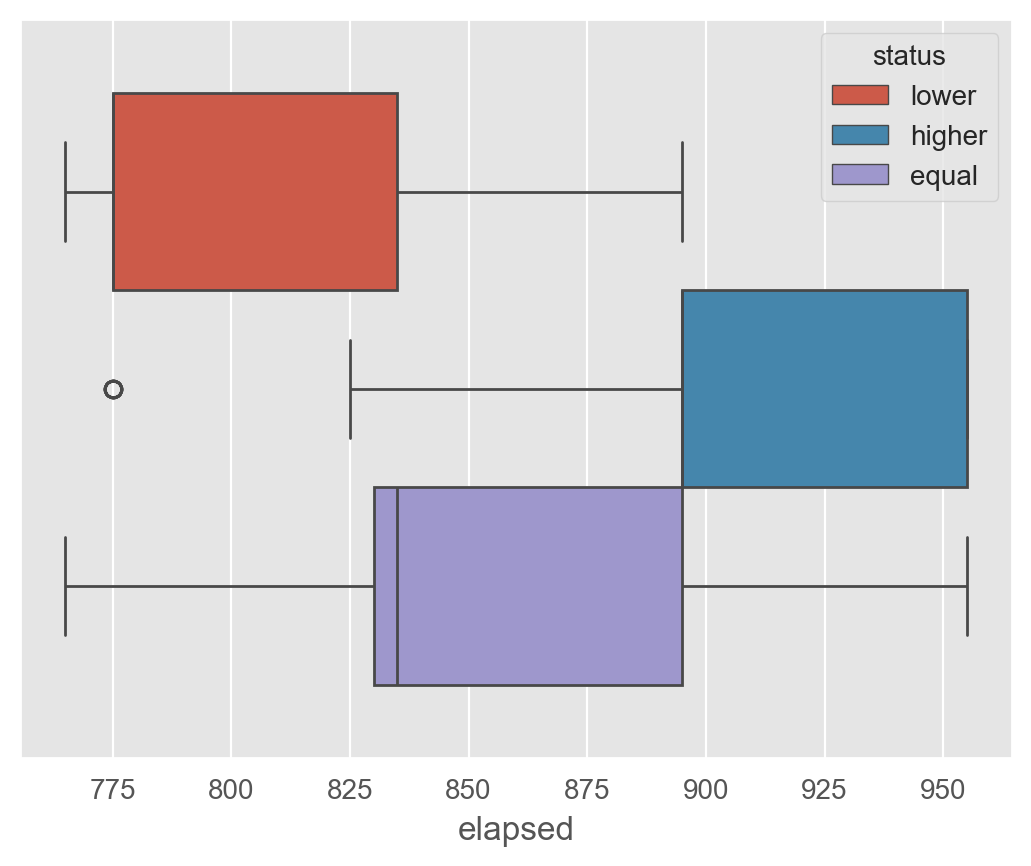

In [23]:
avg_eq_elapsed = aggregated_stats.loc[aggregated_stats["status"] == "equal", "elapsed"].mean()
print(f"Average elapsed time for equal processes: {avg_eq_elapsed:.0f} seconds.")
sns.boxplot(data=aggregated_stats, x="elapsed", hue="status");

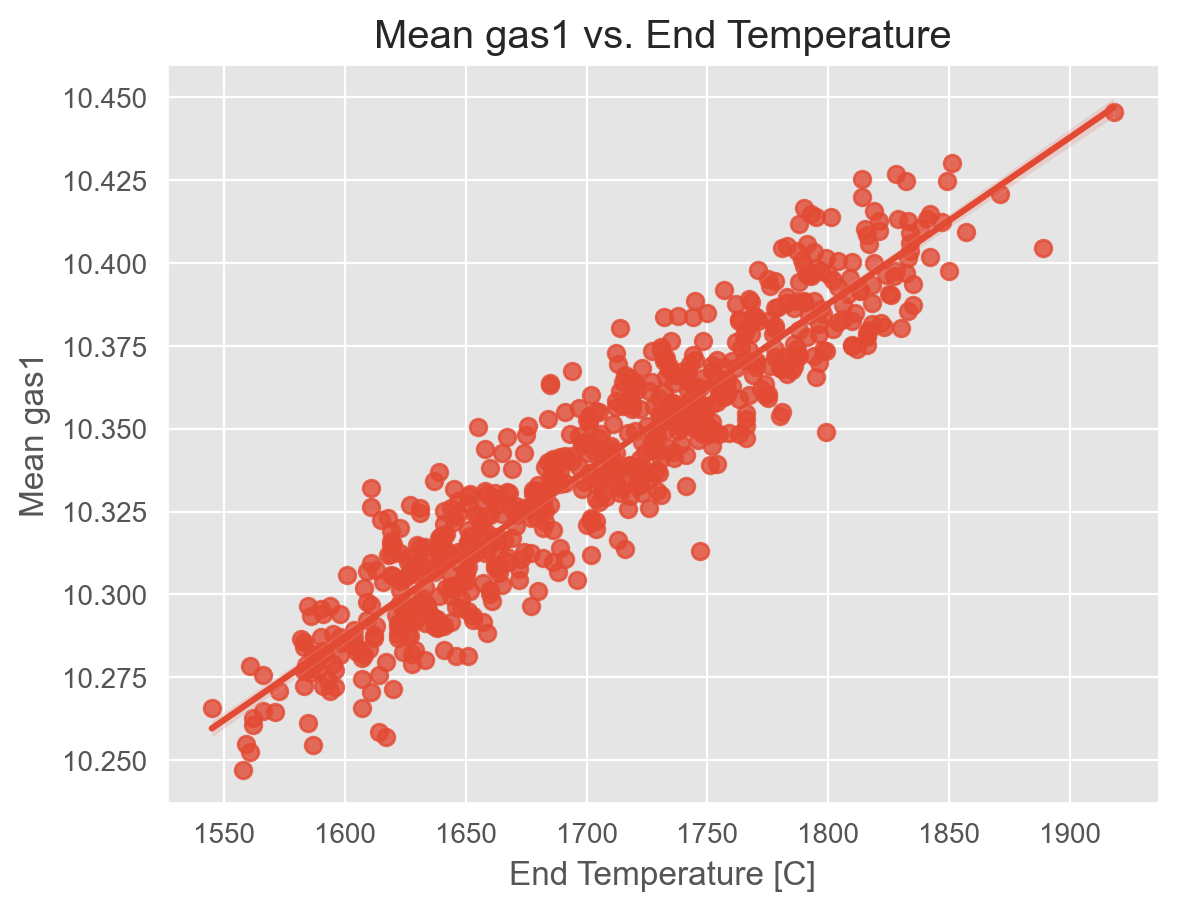

In [24]:
sns.regplot(x="end_t", y="mean_gas1", data=aggregated_stats, marker="o")
plt.title("Mean gas1 vs. End Temperature")
plt.xlabel("End Temperature [C]")
plt.ylabel("Mean gas1")
plt.show();

Now it seems that simple linear regression should do the job from the data amount and complexity perspective.

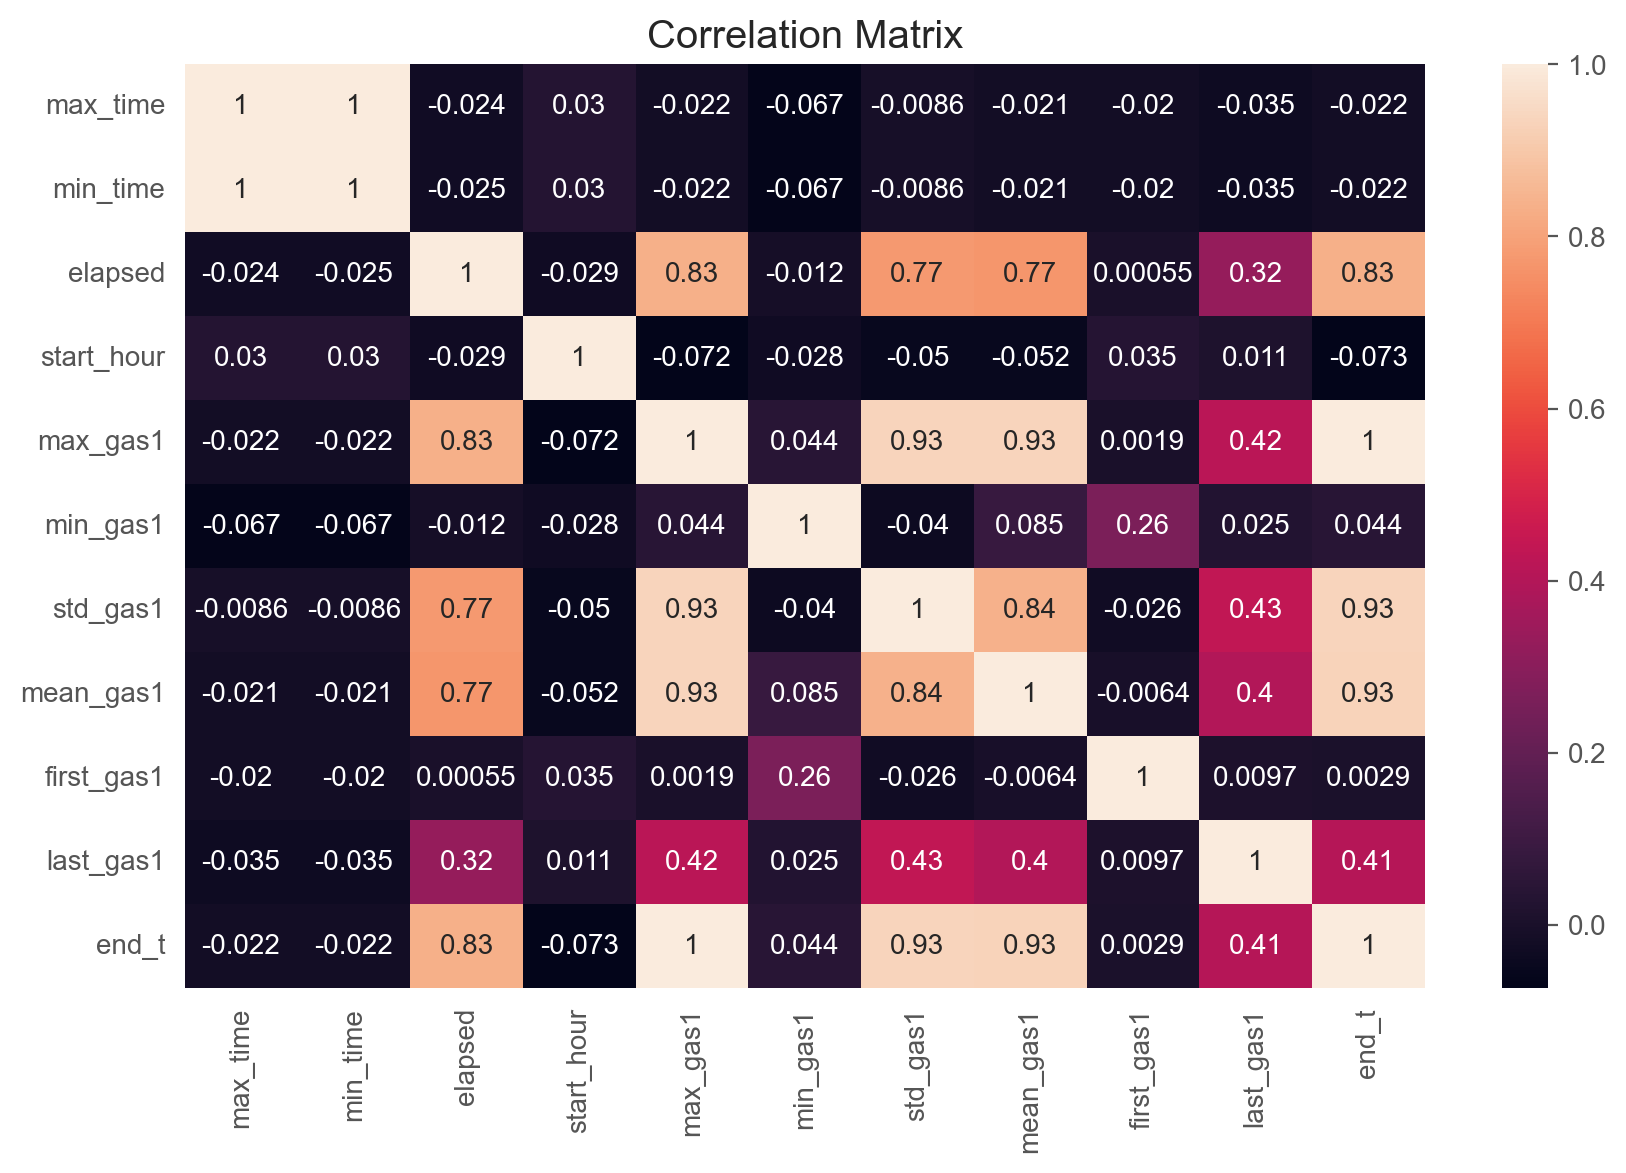

In [25]:
cols_to_corr = [
    "max_time",
    "min_time",
    "elapsed",
    "start_hour",
    "max_gas1",
    "min_gas1",
    "std_gas1",
    "mean_gas1",
    "first_gas1",
    "last_gas1",
    "end_t",
]
corr_matrix = aggregated_stats[cols_to_corr].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

It can be seen that there some quite strong predictors found in the correlation matrix. I will check them vs the model feature importance.

I admit there is some collinearity seen from the plot above, I will apply regularization to fix that later.

The dependencies should be easily captured by simple linear regression.
Though, I will consider random forest or even GBM, since for tabular data the latter models performs better.
I think I will even start with GBM directly mainly to show up nice knowledge of build pipeline with GBM. But also I encounter few pros of XGB:
- fast at inference time, thus it should be a problem for real-time deployment
- easy to interpret
- easy to work with nans and not scaled/normalized features as being tree-based algorithm
- beats many other classical ML algorithms on tabular data
- nicely works with default HP
And cons could be:
- it could be too complex for the problem and could overfit.

From GBM implementation I will use XGB library.

Next, I will calculate these statistics/features which captures process behaviour and feed them to the model while regularizing it.

# Feature Engineering

I create 2 functions for feature calculation:
1. `calculate_historical_features` to batch-calculate features
2. `calculate_current_features` to get features for the current time step for further simulation

In [26]:
def calculate_historical_features(
        df: pd.DataFrame,
        gas_col: str = "gas1",
        temp_col: str = "end_t",
        n_lags: int = 5,
        n_prev_processes: int = 5) -> pd.DataFrame:
    """
    Calculates historical features for each unique "heatid" in the given dataframe. It computes statistical
    aggregations of the specified gas and temperature columns and generates lag-based features and
    elapsed time for each record. Furthermore, it includes features derived from previous processes
    based on `n_prev_processes`.
    :param df: Input pandas DataFrame containing the necessary data columns. The DataFrame must have
        at least "heatid" and "datetime" columns that are utilized for grouping and time-based computations.
    :param gas_col: Column name in the DataFrame representing the gas measurement. Default is "gas1".
    :param temp_col: Column name in the DataFrame representing the temperature measurement. Default is "end_t".
    :param n_lags: Number of lag-based features to generate for the gas measurement column.
    :param n_prev_processes: Number of previous process features to compute based on the temperature column.
    :return: A pandas DataFrame with the original data augmented by the computed historical features.
    :rtype: pd.DataFrame
    """
    df = df.sort_values(["heatid", "datetime"]).copy()
    features_per_heat_id = df.groupby("heatid").agg(
        gas1_mean=(gas_col, "mean"),
        gas1_std=(gas_col, "std"),
        gas1_max=(gas_col, "max"),
        gas1_min=(gas_col, "min"),
        gas1_last=(gas_col, "last"),
        gas1_first=(gas_col, "first"),
        end_t=(temp_col, "first"),
        heatid=("heatid", "first"),
    ).reset_index(drop=True)
    for lag in range(1, n_lags + 1):
        df[f"{gas_col}_lag{lag}"] = df.groupby("heatid")[gas_col].shift(lag)
    for i in range(1, n_prev_processes):
        features_per_heat_id[f"prev_end_t_{i}"] = features_per_heat_id["end_t"].shift(i).iloc[-1]
    features = pd.merge(left=df, right=features_per_heat_id.drop(columns=["end_t"]), on="heatid", how="left")
    features["elapsed"] = df.groupby("heatid")["datetime"].transform(lambda x: (x - x.min()).dt.total_seconds())
    return features


def calculate_current_features(
        df: pd.DataFrame,
        gas_col: str = "gas1",
        n_lags: int = 5,
        n_prev_processes: int = 5,
        feature_order: Iterable | None = None,
) -> pd.DataFrame:
    """
    Computes and returns a DataFrame containing feature calculations for the last heat
    ID group in the input DataFrame. The calculation includes lag features, summary
    statistics for the specified gas column, elapsed time, and optionally reorders
    the columns based on the provided feature order.

    :param df: The input DataFrame containing at least the columns `datetime`, `heatid`,
               `end_t`, and the specified `gas_col` for feature computation.
    :type df: pd.DataFrame
    :param gas_col: The name of the column representing gas measurements to be used
                    for feature calculation.
    :type gas_col: str
    :param n_lags: The number of lagged features to compute for the specified gas column.
                   Default is 5.
    :type n_lags: int
    :param n_prev_processes: The number of previous process end times to include as features.
                             Default is 5.
    :type n_prev_processes: int
    :param feature_order: An optional iterable specifying the desired column order for
                          the output DataFrame.
    :type feature_order: Iterable | None
    :return: A DataFrame with feature calculations for the last heat ID group. The
             resulting DataFrame contains a single row with computed features.
    :rtype: pd.DataFrame
    """
    df = df.sort_values(["datetime"]).copy()
    features_per_heat_id = df.groupby("heatid").agg(end_t=("end_t", "last")).reset_index(drop=True)
    for i in range(1, n_prev_processes + 1):
        df[f"prev_end_t_{i}"] = features_per_heat_id["end_t"].shift(i).iloc[-1]
    for lag in range(1, n_lags + 1):
        df[f"{gas_col}_lag{lag}"] = df.groupby("heatid")[gas_col].shift(lag)
    current_heatid = df["heatid"].iloc[-1]
    df = df.loc[df["heatid"] == current_heatid, :].copy()
    df["heatid"] = current_heatid
    df[f"{gas_col}_mean"] = df[gas_col].mean()
    df[f"{gas_col}_std"] = df[gas_col].std()
    df[f"{gas_col}_max"] = df[gas_col].max()
    df[f"{gas_col}_min"] = df[gas_col].min()
    df[f"{gas_col}_first"] = df[gas_col].iloc[0]
    df[f"{gas_col}_last"] = df[gas_col].iloc[-1]
    df["end_t"] = df["end_t"].iloc[-1]
    df["elapsed"] = (df["datetime"].iloc[-1] - df["datetime"].iloc[0]).total_seconds()
    if feature_order is not None:
        df = df.loc[:, feature_order]
    return df.iloc[[-1]]


def add_process_status(
        df: pd.DataFrame,
        temp_threshold: int | float = TEMP_THRESHOLD,
        temp_band: int | float = TEMP_BAND
) -> pd.DataFrame:
    """
    This function adds a process status column to the given DataFrame based on the temperature
    threshold and temperature band provided. It evaluates the "end_t" column of the DataFrame to
    determine if the value is higher, lower, or equal relative to the threshold and the band. NaN
    values in the "end_t" column will also result in NaN for the "status" column.

    :param df: Input pandas DataFrame that must include "heatid", "datetime", and "end_t" columns.
    :type df: pd.DataFrame
    :param temp_threshold: Temperature threshold used to evaluate the status of "end_t".
    :type temp_threshold: int | float
    :param temp_band: Temperature band to allow for a tolerance around the threshold value.
    :type temp_band: int | float
    :return: A pandas DataFrame with an additional "status" column indicating the relative process status.
    :rtype: pd.DataFrame
    """
    df = df.sort_values(["heatid", "datetime"]).copy()
    df["status"] = np.where(
        df["end_t"] > (temp_threshold + temp_band), "higher",
        np.where(df["end_t"] < (temp_threshold - temp_band), "lower", "equal")
    )
    df.loc[df["end_t"].isna(), "status"] = np.nan
    return df

# Target variable

Since the target `end_t` variable is known only at single time step in the process end, I will `back fill` this value for the whole process.
I will check if the model is able to capture process dynamics while having constant target value during the process.

In [27]:
modeling_data = shifted_data.copy()
modeling_data = add_process_status(modeling_data)
modeling_data["end_t"] = modeling_data.groupby("heatid")["end_t"].bfill()
modeling_data["status"] = modeling_data.groupby("heatid")["status"].bfill()
modeling_data.head(2)

,heatid,datetime,end_t,gas1,status
0,16523,2023-01-01 00:59:55,1648.0,9.847,lower
1,16523,2023-01-01 01:00:00,1648.0,9.850,lower


## Data Split

I will use a single point data split to set up some baseline. I use 2 timestamps for split in order to leave some gap between X_train and X_test to allow temporal statics to accumulate. I choose to leave only 1 day as test data and to have a gap of 1 day between train and test.

Next I might use more splits in CV for HP optimization. As well as I might need to have more balanced split for with respect to the process status of {`higher`, `lower`, `equal`}.

In [28]:
features_data = calculate_historical_features(modeling_data)

train_split = pd.Timestamp("2023-01-29 00:00:00")
test_split = pd.Timestamp("2023-01-30 00:00:00")
features_data.sort_values(by=["datetime"], inplace=True)
X_train = features_data.loc[features_data["datetime"] < train_split].drop(
    columns=["end_t", "heatid", "status", "datetime"])
y_train = features_data.loc[features_data["datetime"] < train_split, ["end_t"]]
X_test = features_data.loc[features_data["datetime"] >= train_split, :]
y_test = features_data.loc[features_data["datetime"] >= train_split, ["end_t"]]
X_train.shape, X_test.shape

((101764, 17), (7223, 21))

# Modeling

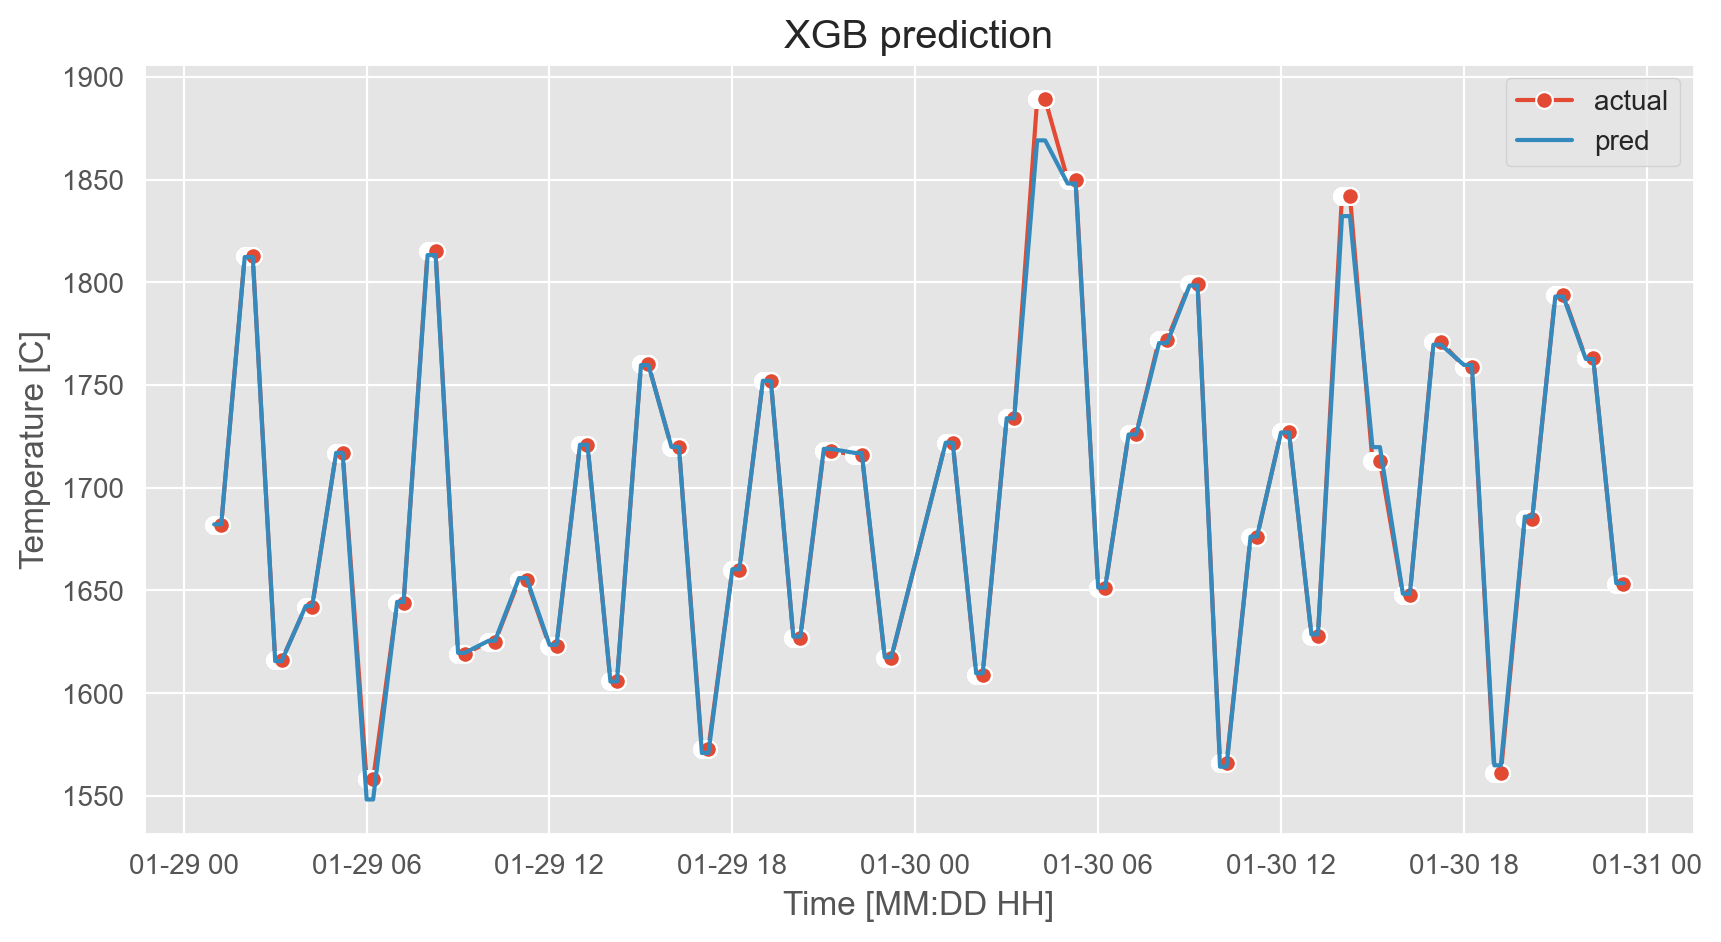

In [29]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    alpha=0.2,
)
model.fit(X_train, y_train)
pred = model.predict(X_test.drop(columns=["end_t", "heatid", "status", "datetime"]))

result = pd.DataFrame(pred, columns=["pred"], index=X_test["datetime"])
actual = pd.Series(y_test.squeeze())
actual.index = result.index
result["actual"] = actual

plt.figure(figsize=(10, 5))
sns.lineplot(data=result, x="datetime", y="actual", label="actual", marker="o")
sns.lineplot(data=result, x="datetime", y="pred", label="pred")
plt.title("XGB prediction")
plt.xlabel("Time [MM:DD HH]")
plt.ylabel("Temperature [C]")
plt.legend()
plt.show()

Let me plot feature importance

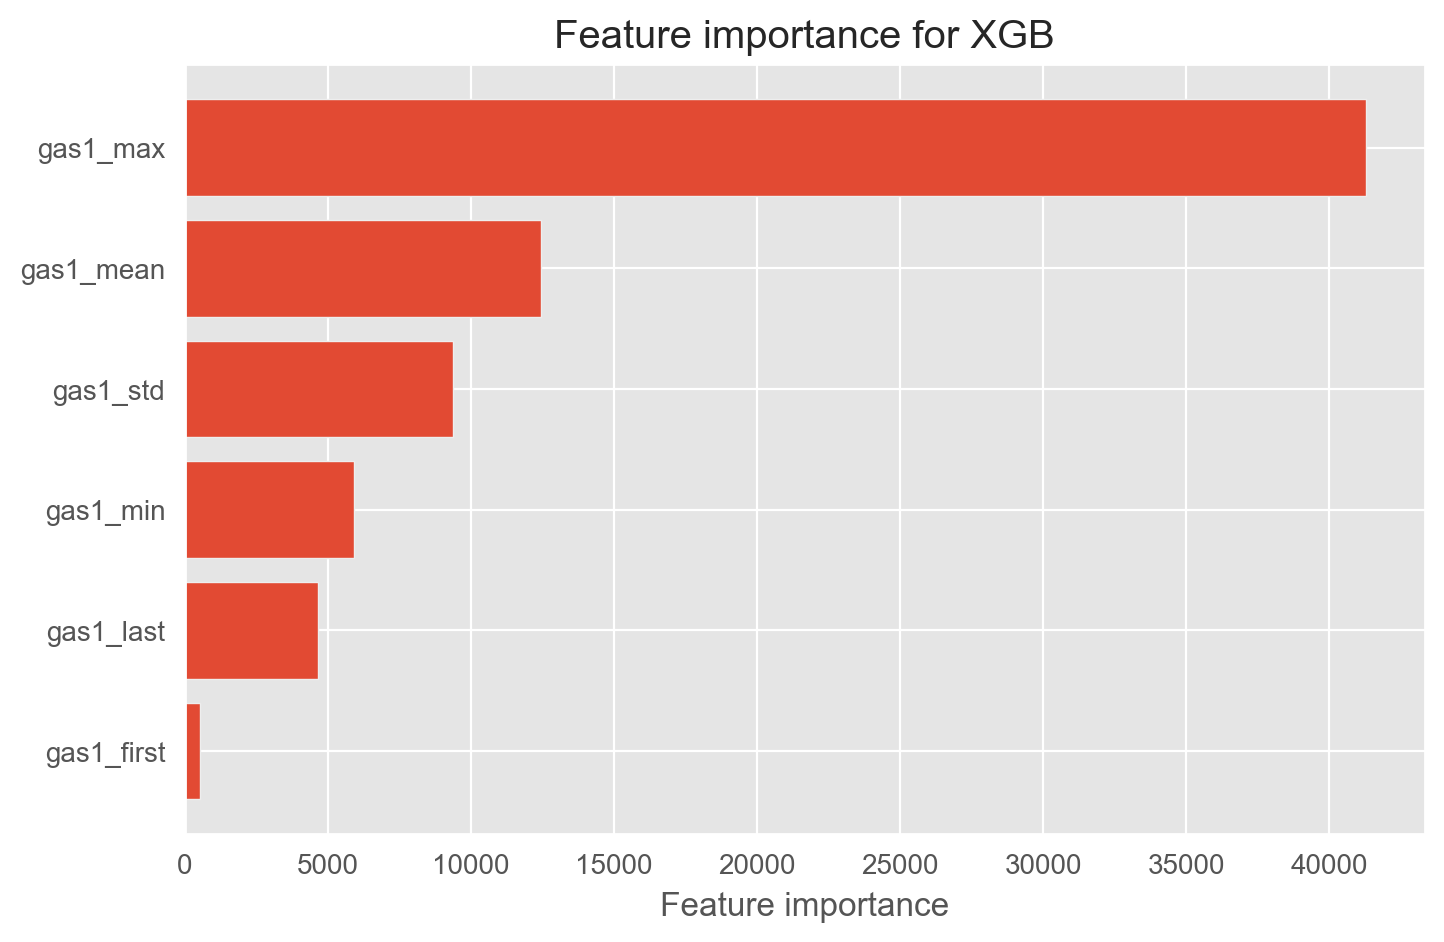

In [30]:
feature_importance = model.get_booster().get_score(importance_type="weight")
feature_importance_df = pd.DataFrame({
    "feature": list(feature_importance.keys()),
    "importance": list(feature_importance.values())
})
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=True)
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.xlabel("Feature importance")
plt.title("Feature importance for XGB")
plt.show();

# Simulation

In [31]:
test_data = features_data.loc[features_data["datetime"] >= train_split, ["datetime", "end_t", "gas1", "heatid"]]
trained_features = model.get_booster().feature_names
features_test_data, predictions = [], []
for idx, row in test_data.loc[test_data["datetime"] >= test_split].iterrows():
    current_data = calculate_current_features(test_data.loc[:idx, :], feature_order=trained_features).reset_index(
        drop=True)
    current_data = current_data.assign(
        datetime=row["datetime"],
        heatid=row["heatid"],
        end_t=row["end_t"],
    )
    current_data = add_process_status(current_data)
    pred = model.predict(current_data.drop(columns=["datetime", "heatid", "status", "end_t"], errors="ignore"))
    predictions.append(
        {"pred": pred[-1],
         "actual": row["end_t"],
         "idx": idx,
         "datetime": row["datetime"],
         "heatid": row["heatid"],
         "status": current_data["status"].values[0],
         "elapsed": current_data["elapsed"].values[0],
         }
    )
pred_data = pd.DataFrame(predictions)
print(pred_data.shape)
pred_data.head(2)

(3682, 7)


,pred,actual,idx,datetime,heatid,status,elapsed
0,1547.848633,1722.0,105305,2023-01-30 00:59:55,17190,higher,0.0
1,1547.848633,1722.0,105306,2023-01-30 01:00:00,17190,higher,5.0


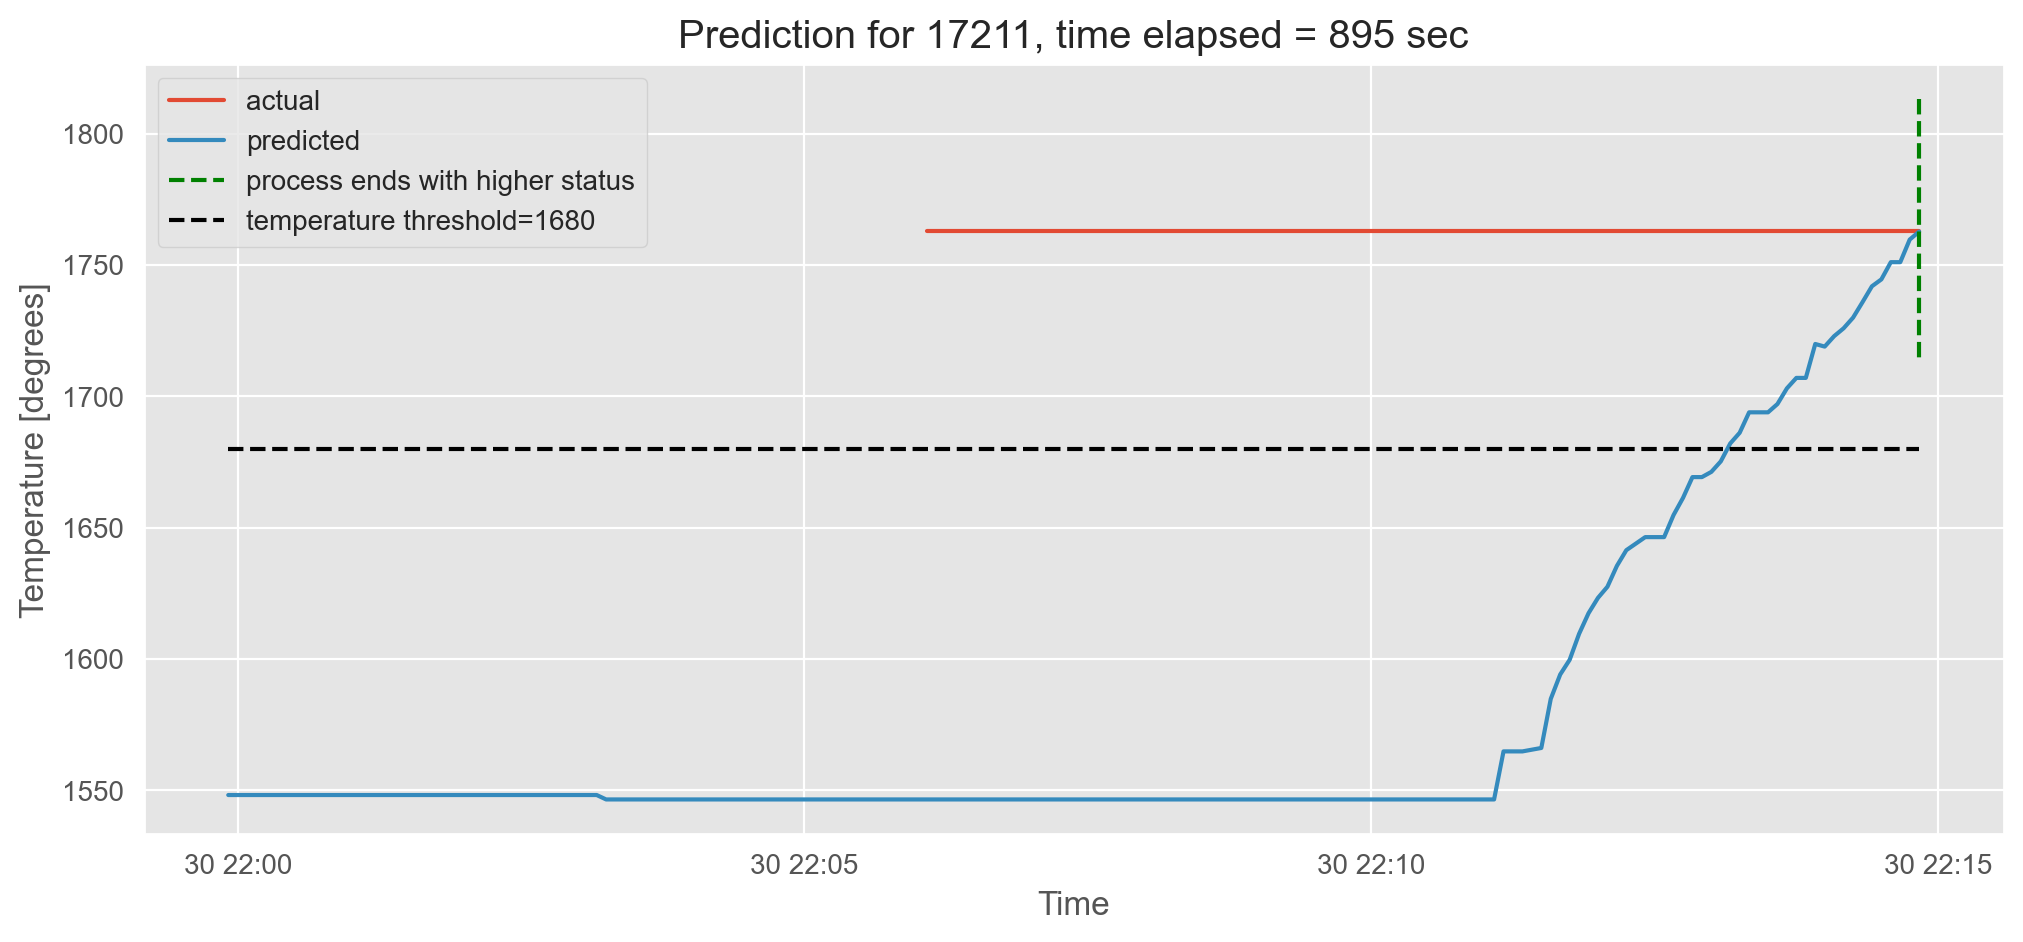

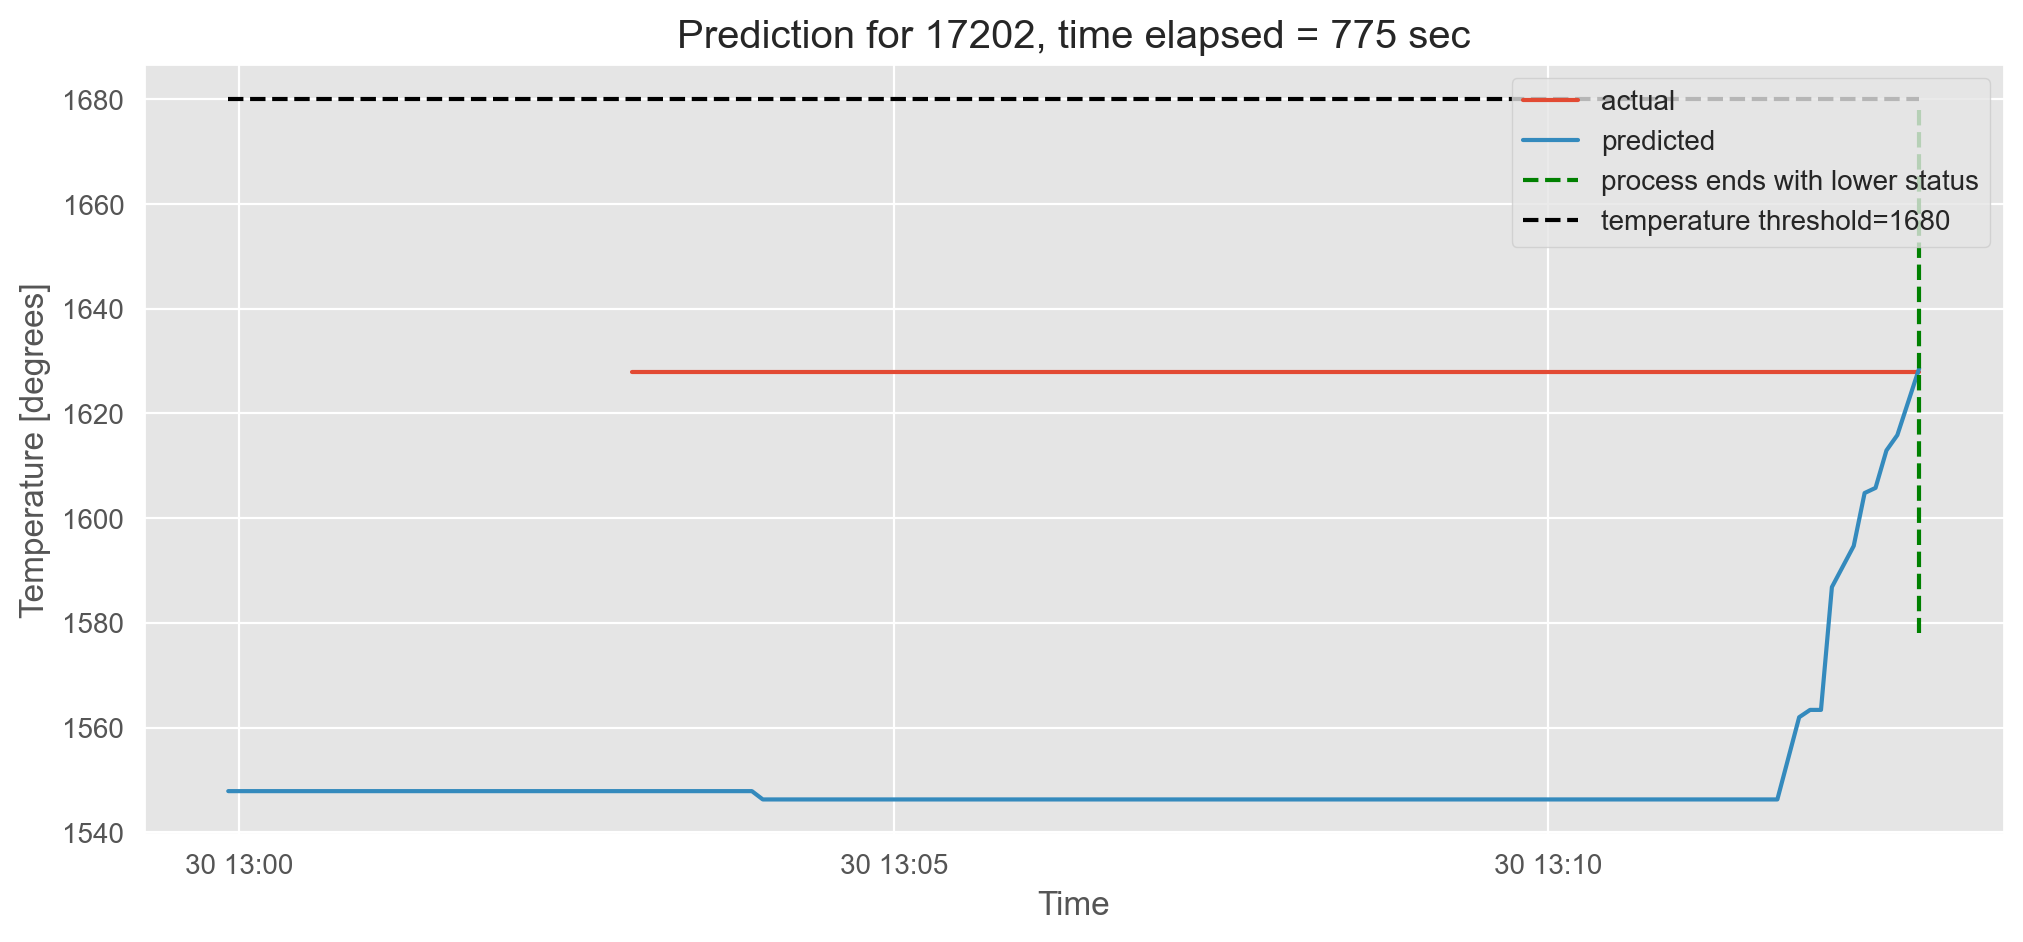

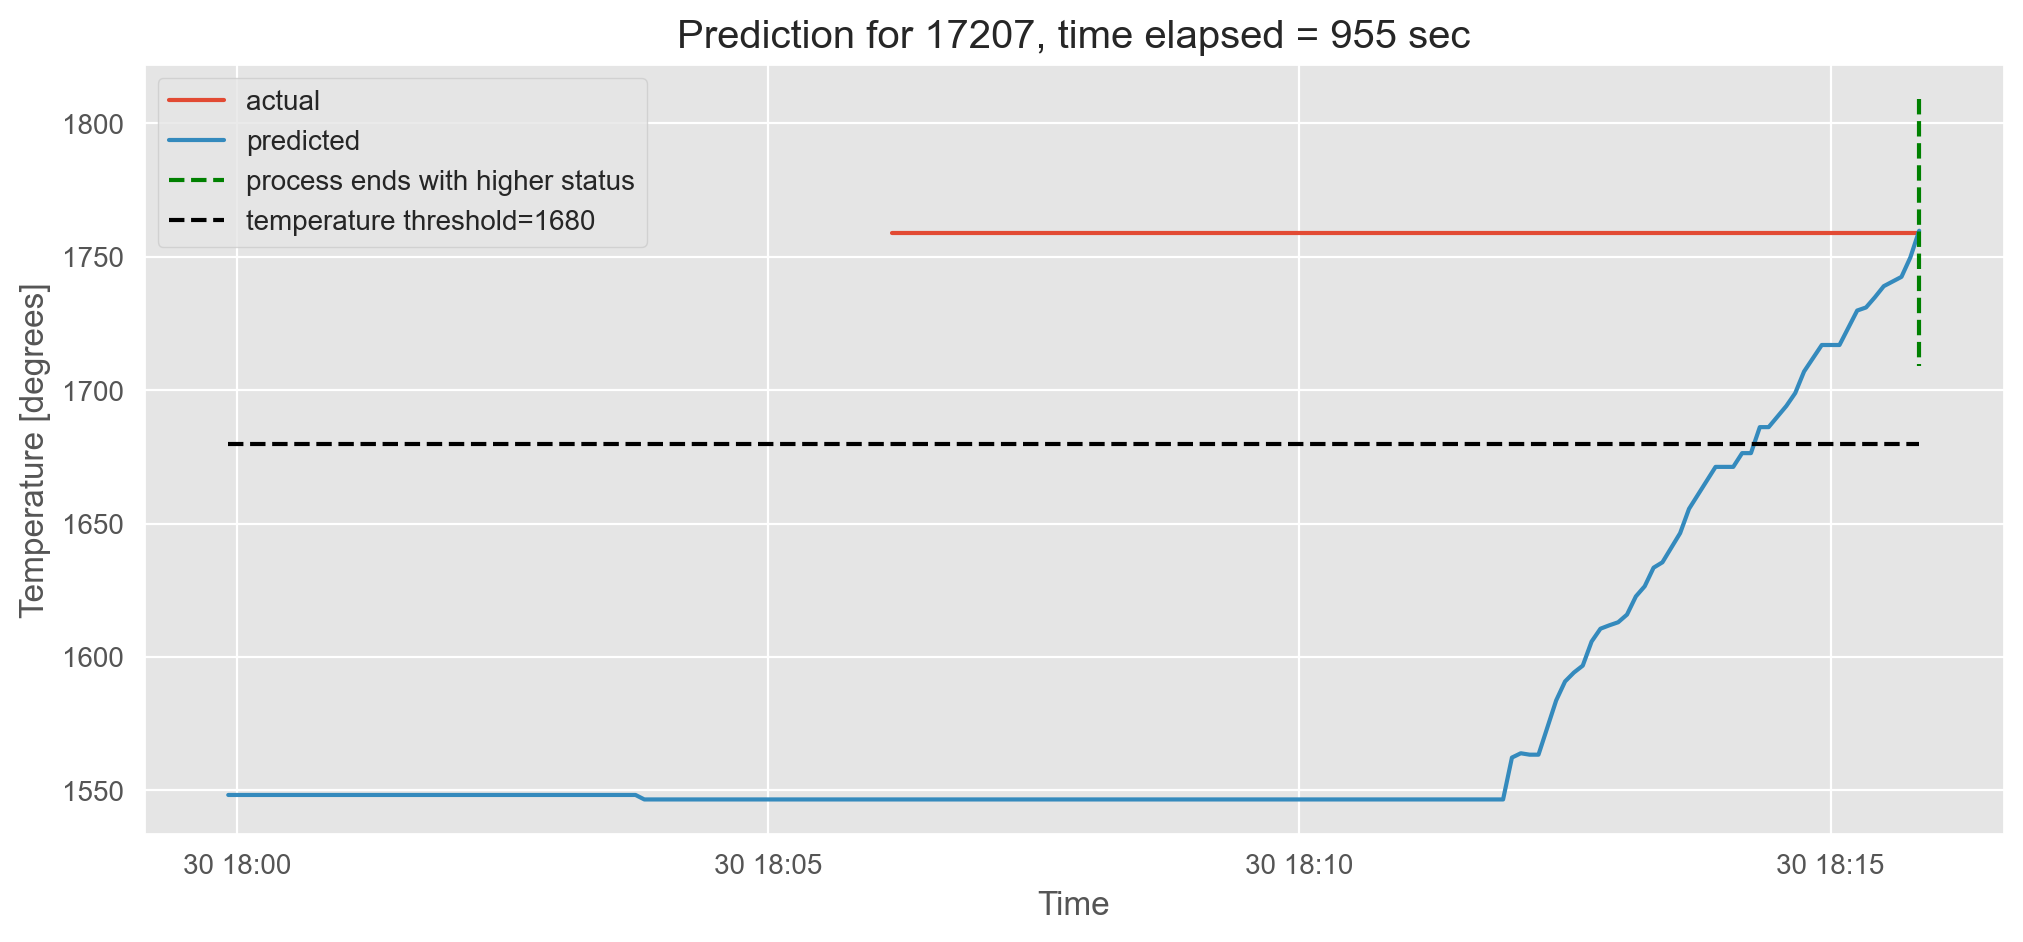

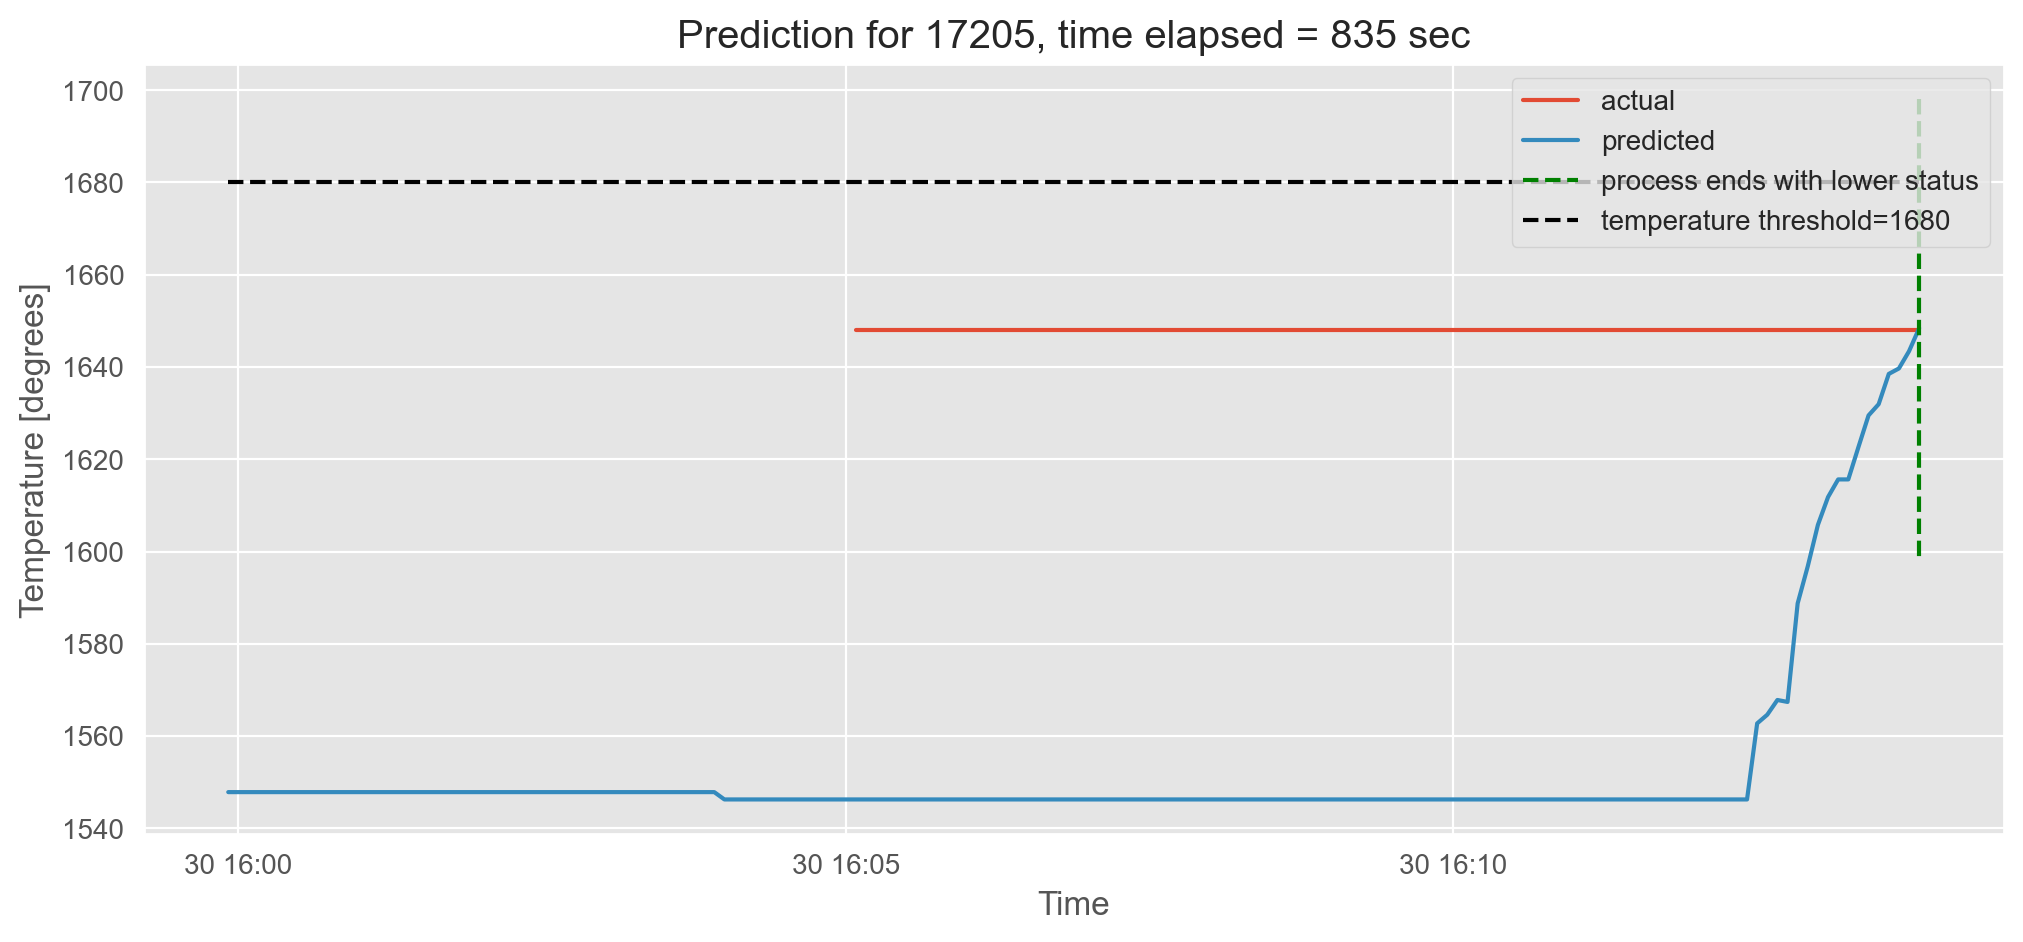

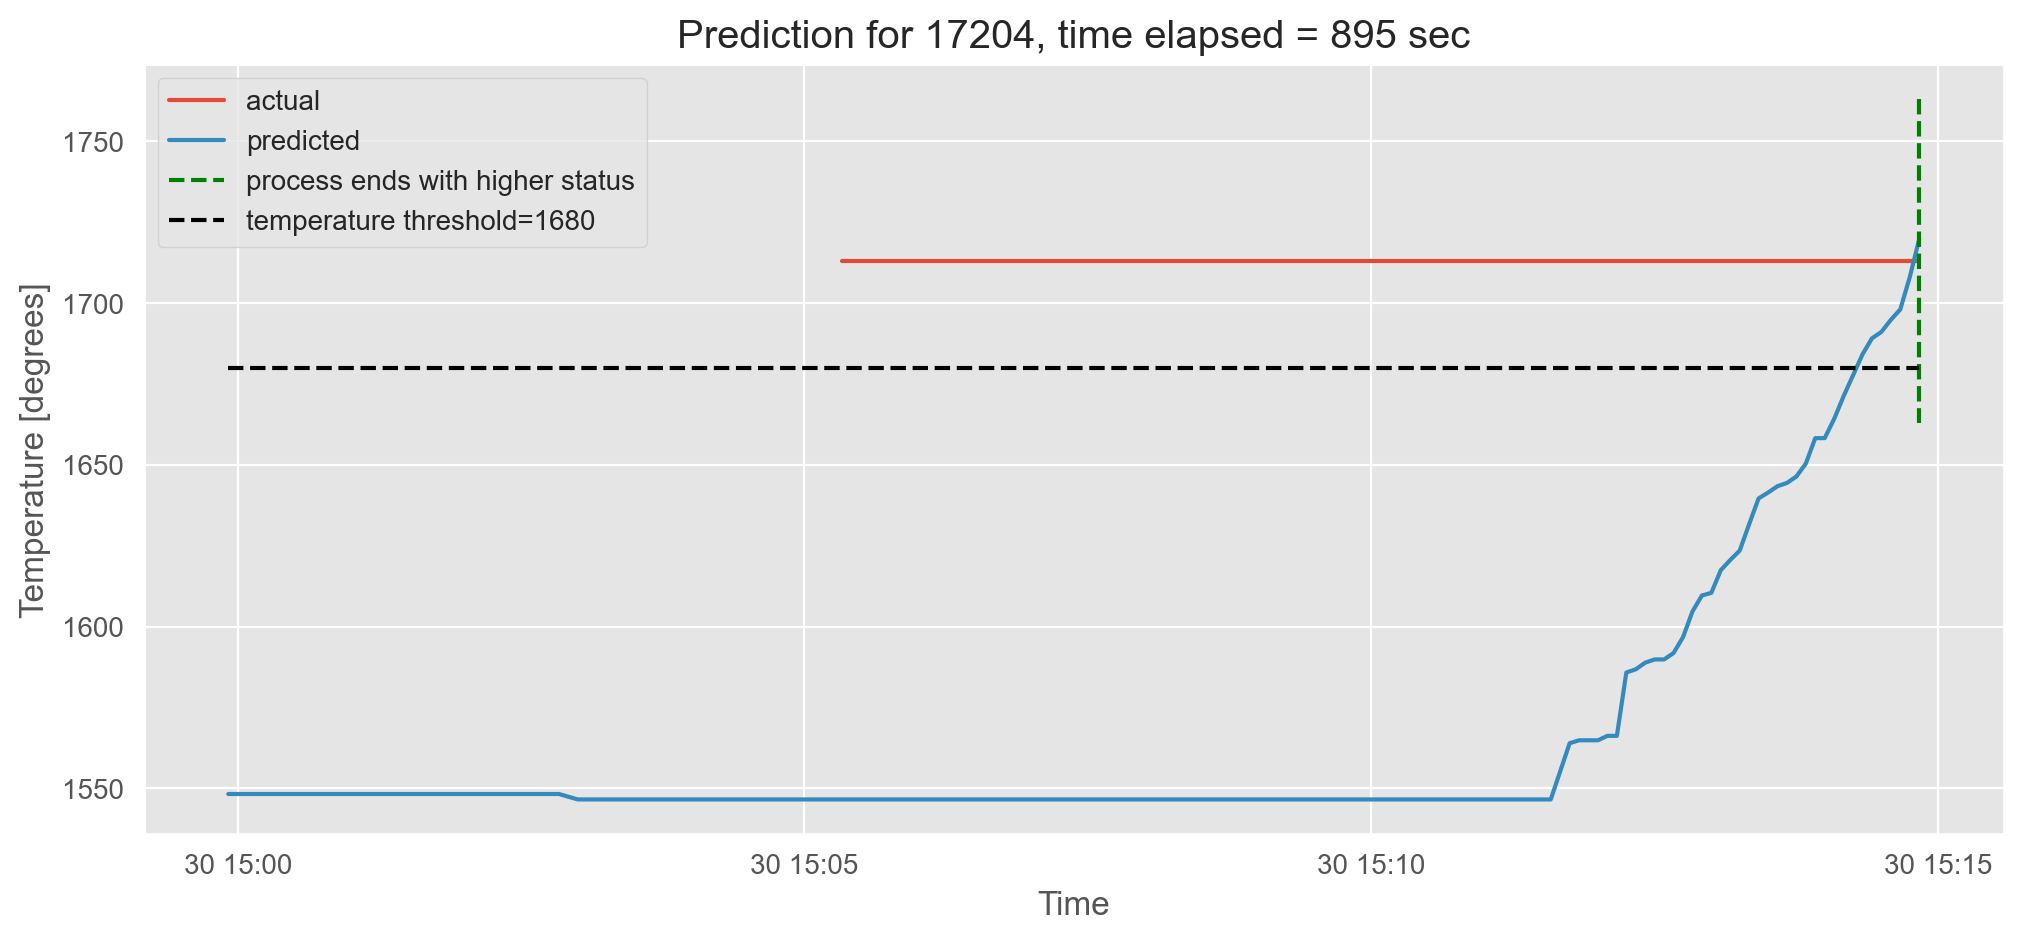

In [32]:
ids = pd.Series(pred_data["heatid"].unique())
_delta = 50
for _id in ids.sample(5, random_state=3):
    plot_data = pred_data.loc[pred_data["heatid"] == _id, ["actual", "pred", "datetime", "status"]]
    plt.figure(figsize=(12, 5))
    plt.plot(plot_data[-100:]["datetime"], plot_data.iloc[-100:]["actual"], label="actual")
    plt.plot(plot_data["datetime"], plot_data["pred"], label="predicted")
    elapsed = pred_data.loc[pred_data["heatid"] == _id, "elapsed"].iloc[-1]
    status_row = plot_data.loc[~plot_data["status"].isna(), "datetime"]
    status = plot_data.loc[~plot_data["status"].isna(), "status"].iloc[0]
    plt.vlines(x=plot_data["datetime"].iloc[-1], ymin=plot_data["actual"].min() + _delta,
               ymax=plot_data["actual"].max() - _delta,
               linestyles="--", colors="green", label=f"process ends with {status} status")
    plt.hlines(y=TEMP_THRESHOLD, xmin=plot_data["datetime"].min(), xmax=plot_data["datetime"].max(), linestyles="--",
               colors="k", label=f"temperature threshold={TEMP_THRESHOLD}")
    plt.title(f"Prediction for {_id}, time elapsed = {elapsed:.0f} sec")
    plt.xlabel("Time")
    plt.ylabel("Temperature [degrees]")
    plt.legend()
    plt.show()

In [42]:
agg_pred = pred_data.groupby("heatid").agg(pred=("pred", "last"), y_true=("actual", "last"))
mse = mean_squared_error(y_true=agg_pred["y_true"], y_pred=agg_pred["pred"])
mae = mean_absolute_error(y_true=agg_pred["y_true"], y_pred=agg_pred["pred"])
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

MSE: 24.75, MAE: 2.34


Looks like the model learned desired dependencies from the data and reaches the actual `end_t` at the process end.
It seems that the crossing `1680` C threshold can be used as a signal to stop the process. This signal can be combined with the discrete operation modes.


Few ideas on how to improve:
1. To optimize the main hyper-parameters of the XGB.
2. To use asymmetric loss for the model training, which can help model ot incorporate the costs knowledge about the process dynamics.
3. To use some weights for the features to indicate the latest period of the process is of high importance (I will apply rule of thumb and will calculate loss starting from 700 sec of process).
4. Use more data.
5. Use conformal intervals instead of point forecasting.


# HP Optimization

I will start with the most important HP and will use [Optuna](https://optuna.readthedocs.io/en/stable/index.html) for the purpose as it is a great lib with a bunch of optimization methods and a friendly API.
Since each process starts after previous one I will use group K-folds splitter to bound model training and prediction for the process with no risk of data leakage during splits.

Finally, I will use simplified parameters space for HP optimization for a sake of time while commenting out rest important HP I might optimize.


In [35]:
def get_xgb_params(trial: optuna.Trial) -> dict[str, float | int]:
    return {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        # "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        # "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        # "n_estimators": trial.suggest_int("n_estimators", 100, 1_500),
        # "lambda": trial.suggest_float("lambda", 0.01, 1),
        # "alpha": trial.suggest_float("alpha", 0.01, 1),
    }

Prepare the data and CV splitter for HP.

In [217]:
features_data = calculate_historical_features(modeling_data)
train_split = pd.Timestamp("2023-01-29 00:00:00")
test_split = pd.Timestamp("2023-01-30 00:00:00")
features_data.sort_values(by=["heatid", "datetime"], inplace=True)
X_train = features_data.loc[features_data["datetime"] < train_split].drop(
    columns=["end_t", "status", "datetime"]
)
y_train = features_data.loc[features_data["datetime"] < train_split, ["end_t"]]
X_val = features_data.loc[features_data["datetime"] >= train_split, ["gas1", "datetime", "status"]]
y_val = features_data.loc[features_data["datetime"] >= train_split, ["end_t"]]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((101764, 18), (101764, 1), (7223, 3), (7223, 1))

Let's create asymmetric cost function which penalizes more for the process early stopped as well as uses weights to start penalizing after certain amount of time passed since process has begun:

In [45]:
def asymmetric_cost_metric(
        y_pred: pd.Series,
        t_threshold: int | float = TEMP_THRESHOLD,
        cost_below: int = COST_BELOW,
        cost_above: int = COST_ABOVE,
        weights: np.ndarray | None = None
) -> float | np.ndarray:
    cost = np.where(y_pred < t_threshold, cost_below, cost_above * np.floor((y_pred - t_threshold) / cost_above))
    if weights is None:
        return np.mean(cost)
    return np.mean(cost * weights)

I will use group/process splits fold CV strategy (`GroupKFold`) with 10 splits for now.

In [219]:
n_splits = 30
ids = X_train["heatid"]
X_train.drop(columns=["heatid"], inplace=True)

In [220]:
def objective(trial: optuna.Trial) -> float:
    """
    Evaluates an objective function using a GroupKFold cross-validation approach. This
    function aims to minimize the mean of a custom asymmetric cost metric over multiple
    folds, using an `xgboost` model whose hyperparameters are determined dynamically by
    Optuna's `Trial` object.

    :param trial: An instance of `optuna.Trial` used to sample hyperparameters.
    :type trial: optuna.Trial
    :return: Mean asymmetric cost metric calculated across all folds of the GroupKFold
      cross-validation.
    :rtype: float
    """
    gkf = GroupKFold(n_splits=n_splits, shuffle=False)
    fold_errors = []
    for train_idx, test_idx in gkf.split(X_train, y_train["end_t"], groups=ids):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model = xgb.XGBRegressor(**get_xgb_params(trial))
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_test_fold)
        weights = np.where(X_test_fold["elapsed"] >= ASYM_METRIC_ELAPSED, 1, 0)
        fold_error = asymmetric_cost_metric(preds, weights=weights)
        fold_errors.append(fold_error)
    return np.mean(fold_errors)

In [221]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best hyperparameters:", study.best_params)
print("Best weighted asymmetric metric:", study.best_value)

[I 2025-02-21 06:53:24,646] A new study created in memory with name: no-name-30681605-707e-4dbb-ac3f-f6863760e45d
[I 2025-02-21 06:53:37,298] Trial 0 finished with value: 15.98064088344751 and parameters: {'max_depth': 9}. Best is trial 0 with value: 15.98064088344751.
[I 2025-02-21 06:53:47,781] Trial 1 finished with value: 15.994931725461631 and parameters: {'max_depth': 8}. Best is trial 0 with value: 15.98064088344751.
[I 2025-02-21 06:53:58,406] Trial 2 finished with value: 15.97598057849844 and parameters: {'max_depth': 12}. Best is trial 2 with value: 15.97598057849844.
[I 2025-02-21 06:54:05,956] Trial 3 finished with value: 15.993349693353435 and parameters: {'max_depth': 6}. Best is trial 2 with value: 15.97598057849844.
[I 2025-02-21 06:54:13,408] Trial 4 finished with value: 15.993349693353435 and parameters: {'max_depth': 6}. Best is trial 2 with value: 15.97598057849844.


Best hyperparameters: {'max_depth': 12}
Best weighted asymmetric metric: 15.97598057849844


In [222]:
model = xgb.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

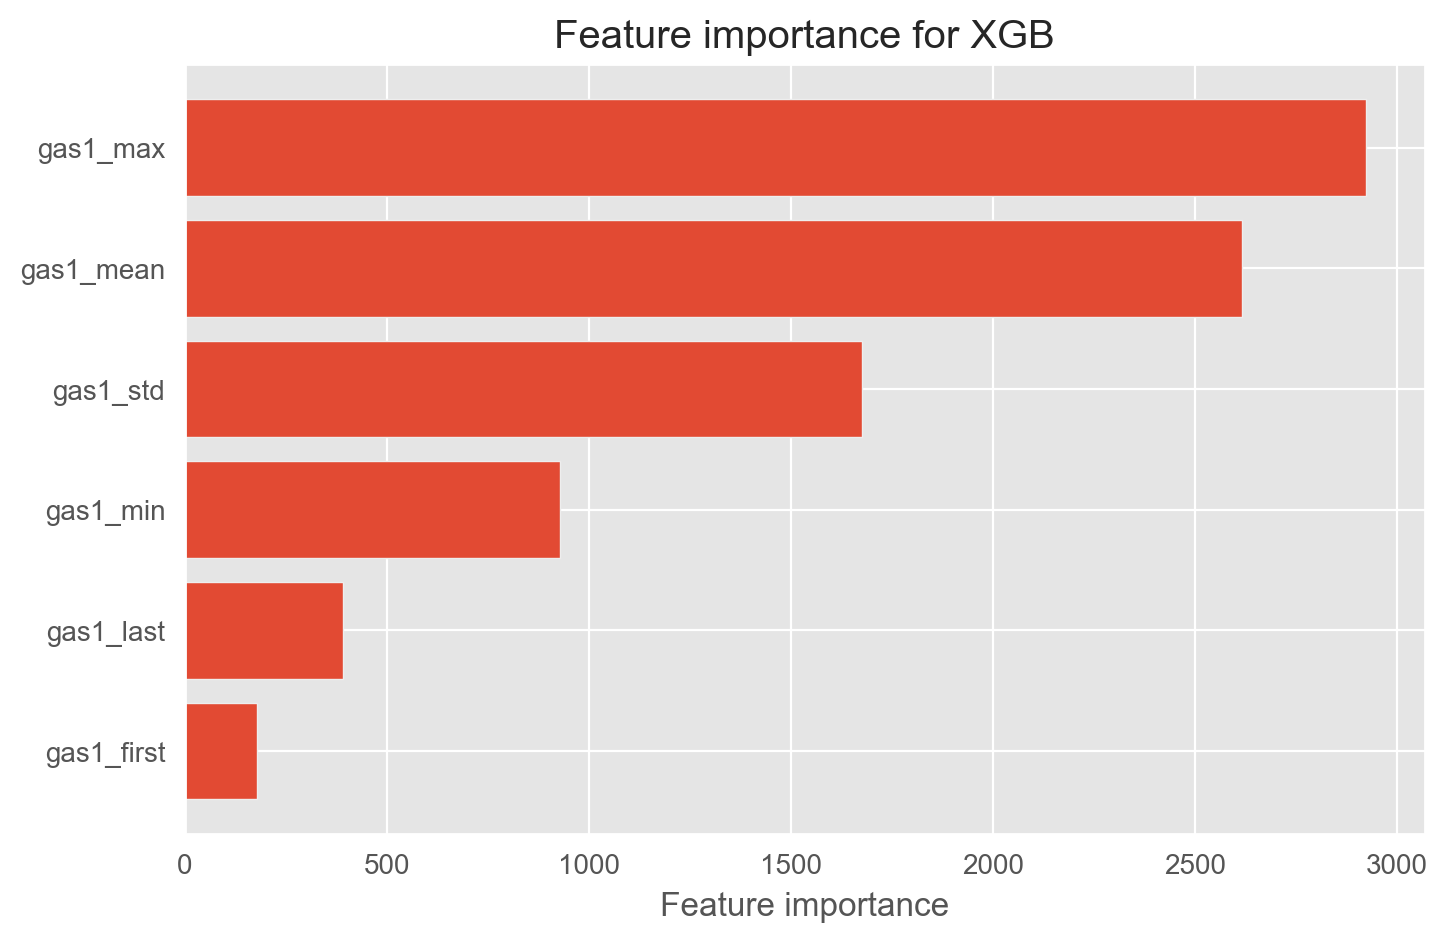

In [223]:
feature_importance = model.get_booster().get_score(importance_type="weight")
feature_importance_df = pd.DataFrame({
    "feature": list(feature_importance.keys()),
    "importance": list(feature_importance.values())
})
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=True)
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.xlabel("Feature importance")
plt.title("Feature importance for XGB")
plt.show();

Let's perform the final simulation

In [224]:
test_data = features_data.loc[features_data["datetime"] >= train_split, ["datetime", "end_t", "gas1", "heatid"]]
trained_features = model.get_booster().feature_names
features_test_data, predictions = [], []
for idx, row in test_data.loc[test_data["datetime"] >= test_split].iterrows():
    current_data = calculate_current_features(test_data.loc[:idx, :], feature_order=trained_features).reset_index(
        drop=True)
    current_data = current_data.assign(
        datetime=row["datetime"],
        heatid=row["heatid"],
        end_t=row["end_t"],
    )
    current_data = add_process_status(current_data)
    pred = model.predict(current_data.drop(columns=["datetime", "heatid", "status", "end_t"], errors="ignore"))
    predictions.append(
        {"pred": pred[-1],
         "actual": row["end_t"],
         "idx": idx,
         "datetime": row["datetime"],
         "heatid": row["heatid"],
         "status": current_data["status"].values[0],
         "elapsed": current_data["elapsed"].values[0],
         }
    )
pred_data = pd.DataFrame(predictions)
print(pred_data.shape)
pred_data.head(2)

(3682, 7)


,pred,actual,idx,datetime,heatid,status,elapsed
0,1547.922729,1722.0,105305,2023-01-30 00:59:55,17190,higher,0.0
1,1547.922485,1722.0,105306,2023-01-30 01:00:00,17190,higher,5.0


Let see how the assymetric metric look like for final simulation data.

mean asymmetric_metric = 88.26


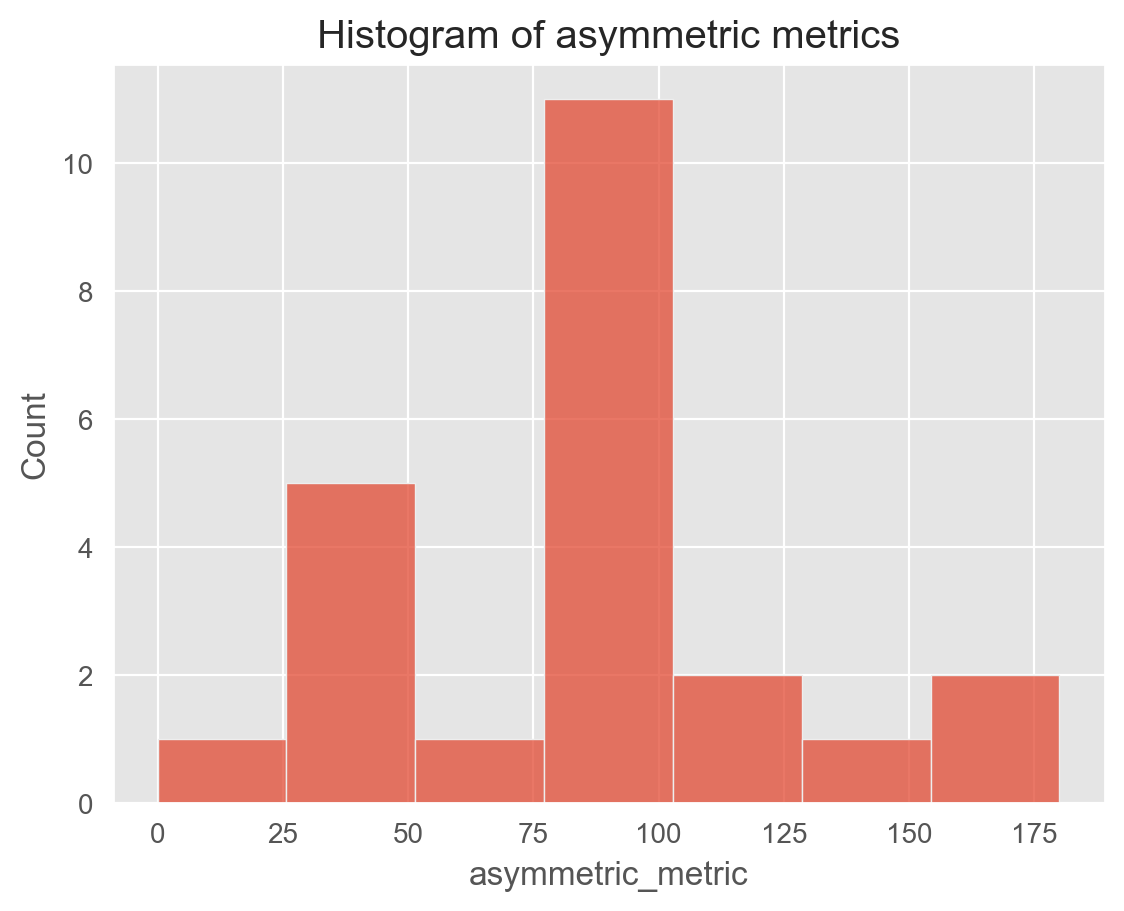

In [94]:
asymmetric_metrics = []
for _id, group in pred_data.groupby("heatid"):
    group = group.iloc[-1]
    metric = asymmetric_cost_metric(y_pred=group["pred"])
    asymmetric_metrics.append(metric)
asymmetric_metrics = pd.DataFrame(asymmetric_metrics, columns=["asymmetric_metric"])
print(f"mean asymmetric_metric = {np.mean(asymmetric_metrics):.2f}")
sns.histplot(x=asymmetric_metrics["asymmetric_metric"])
plt.title("Histogram of asymmetric metrics")
plt.show();

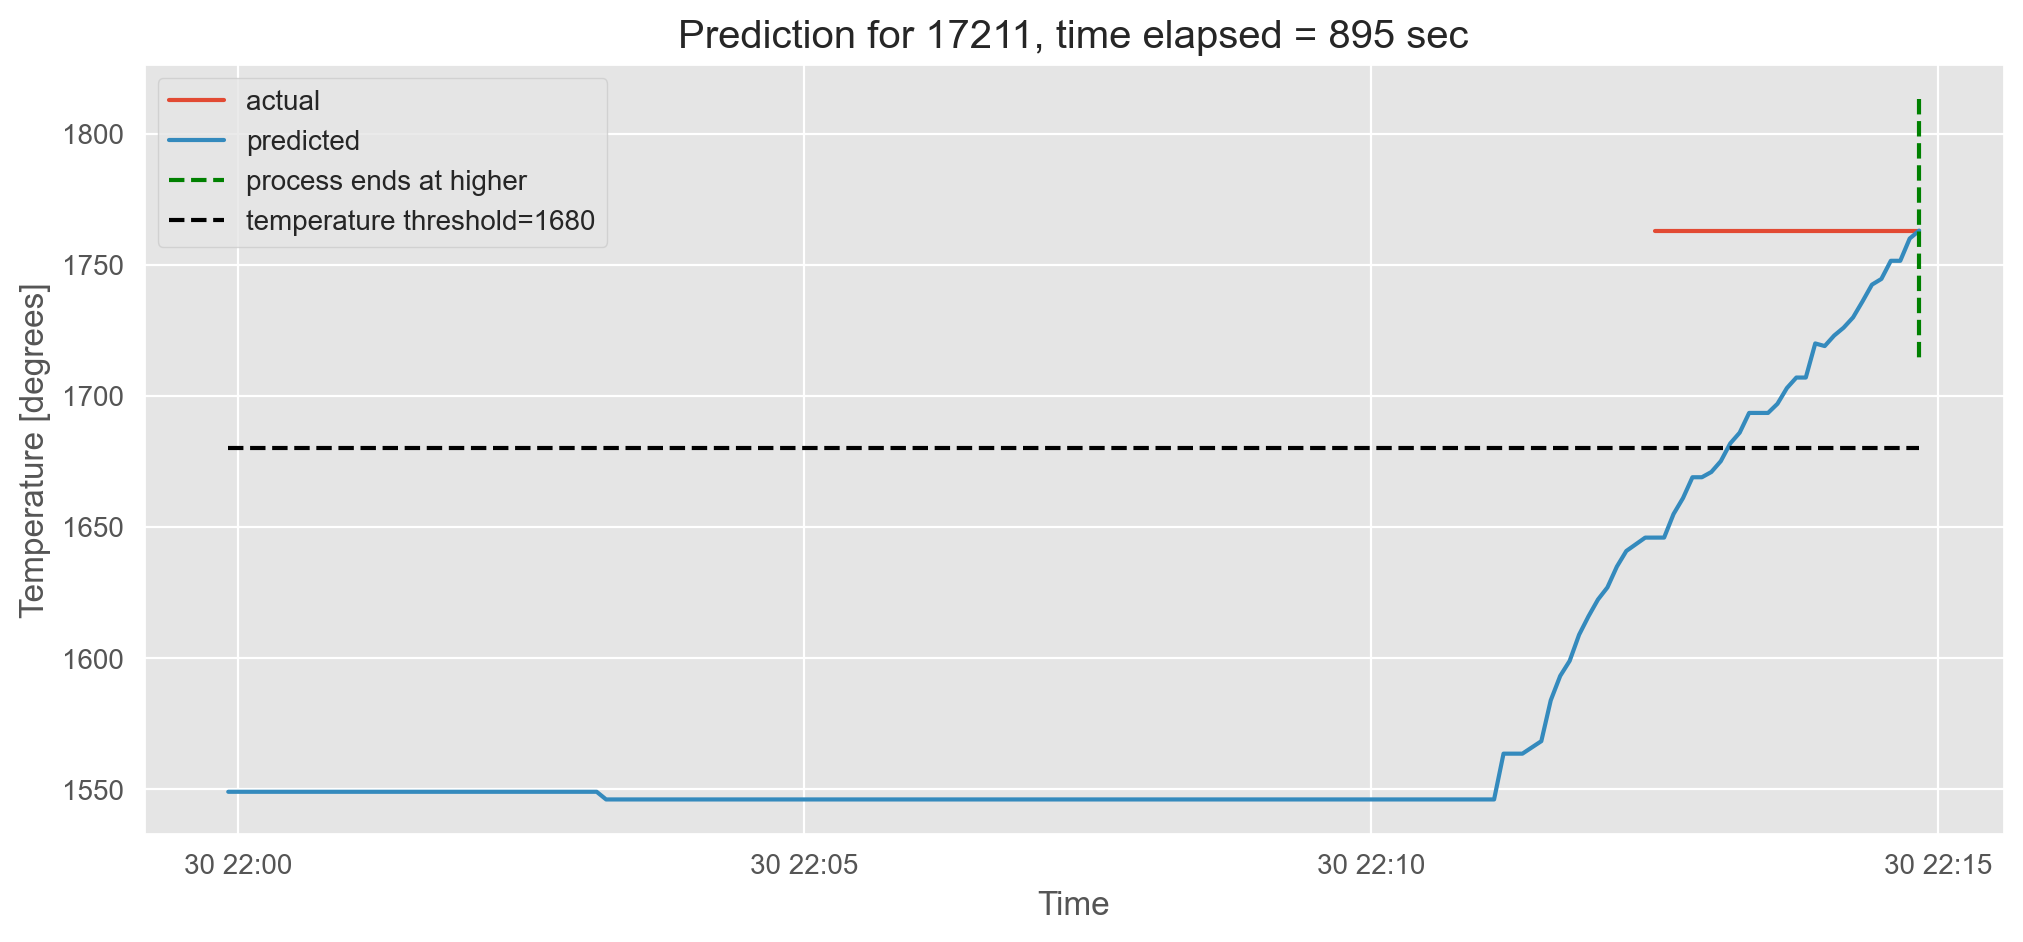

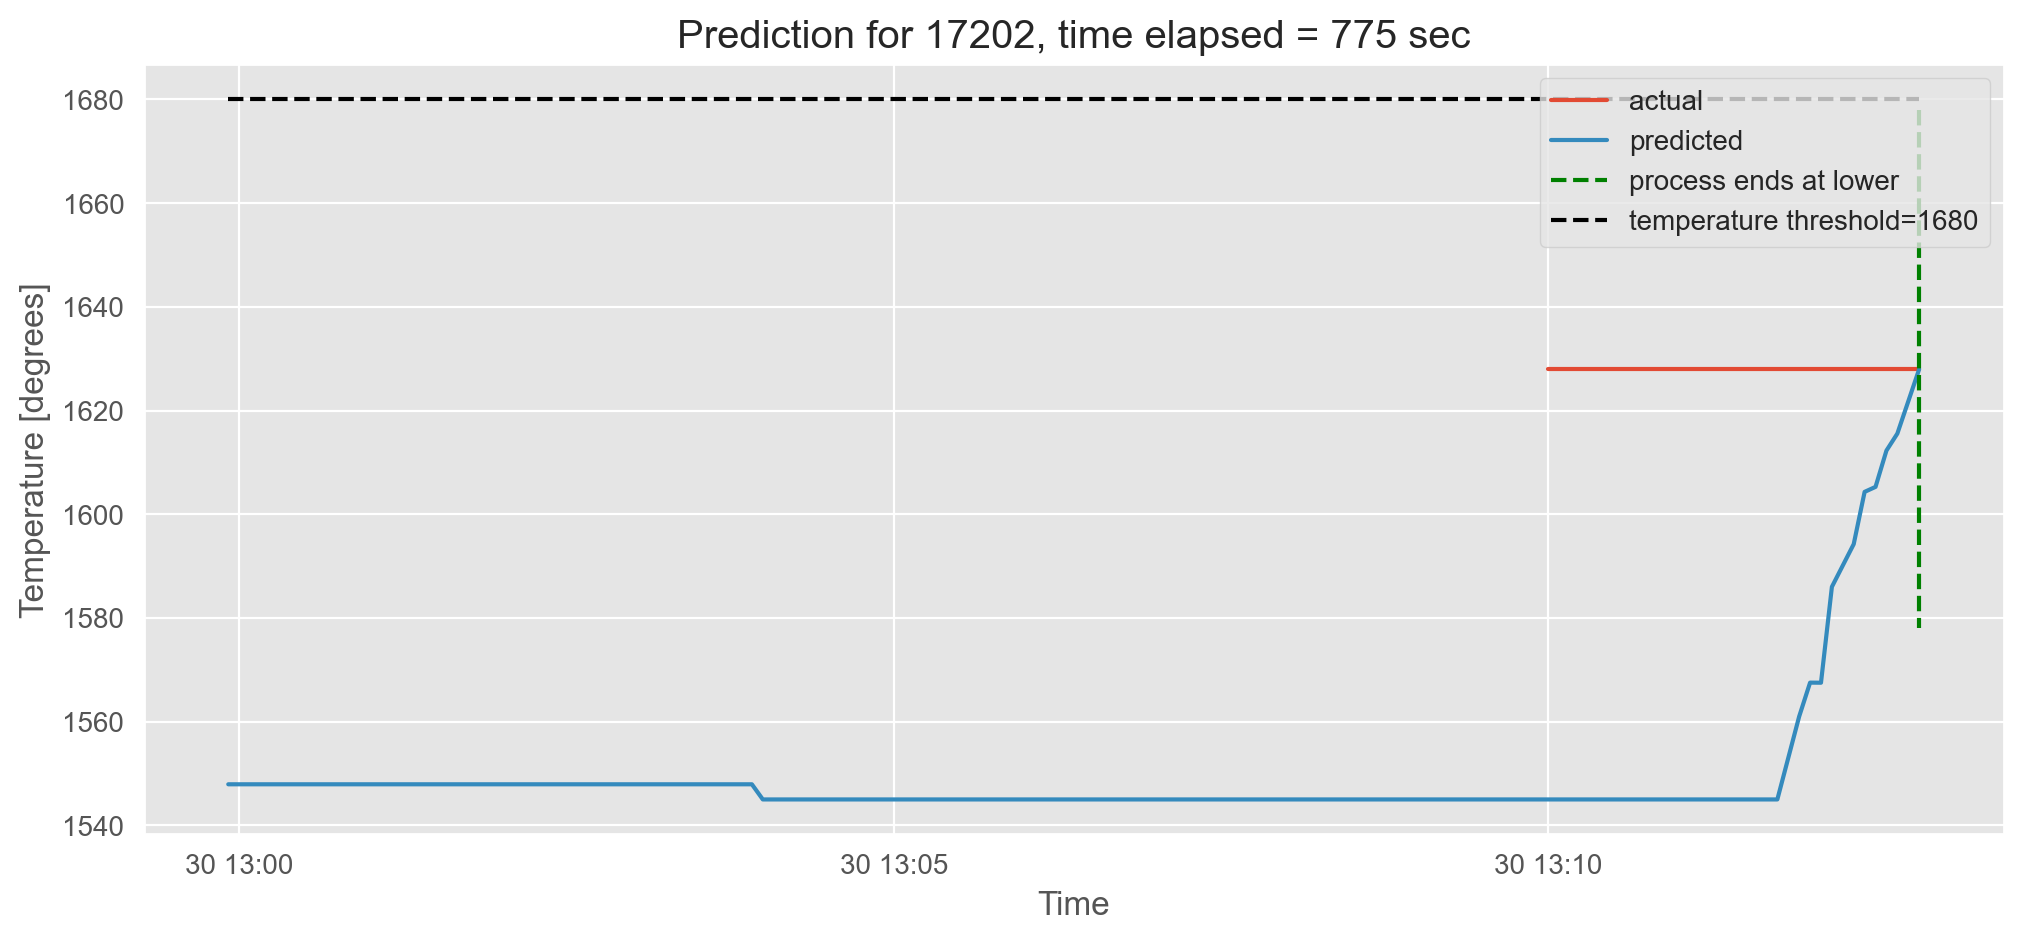

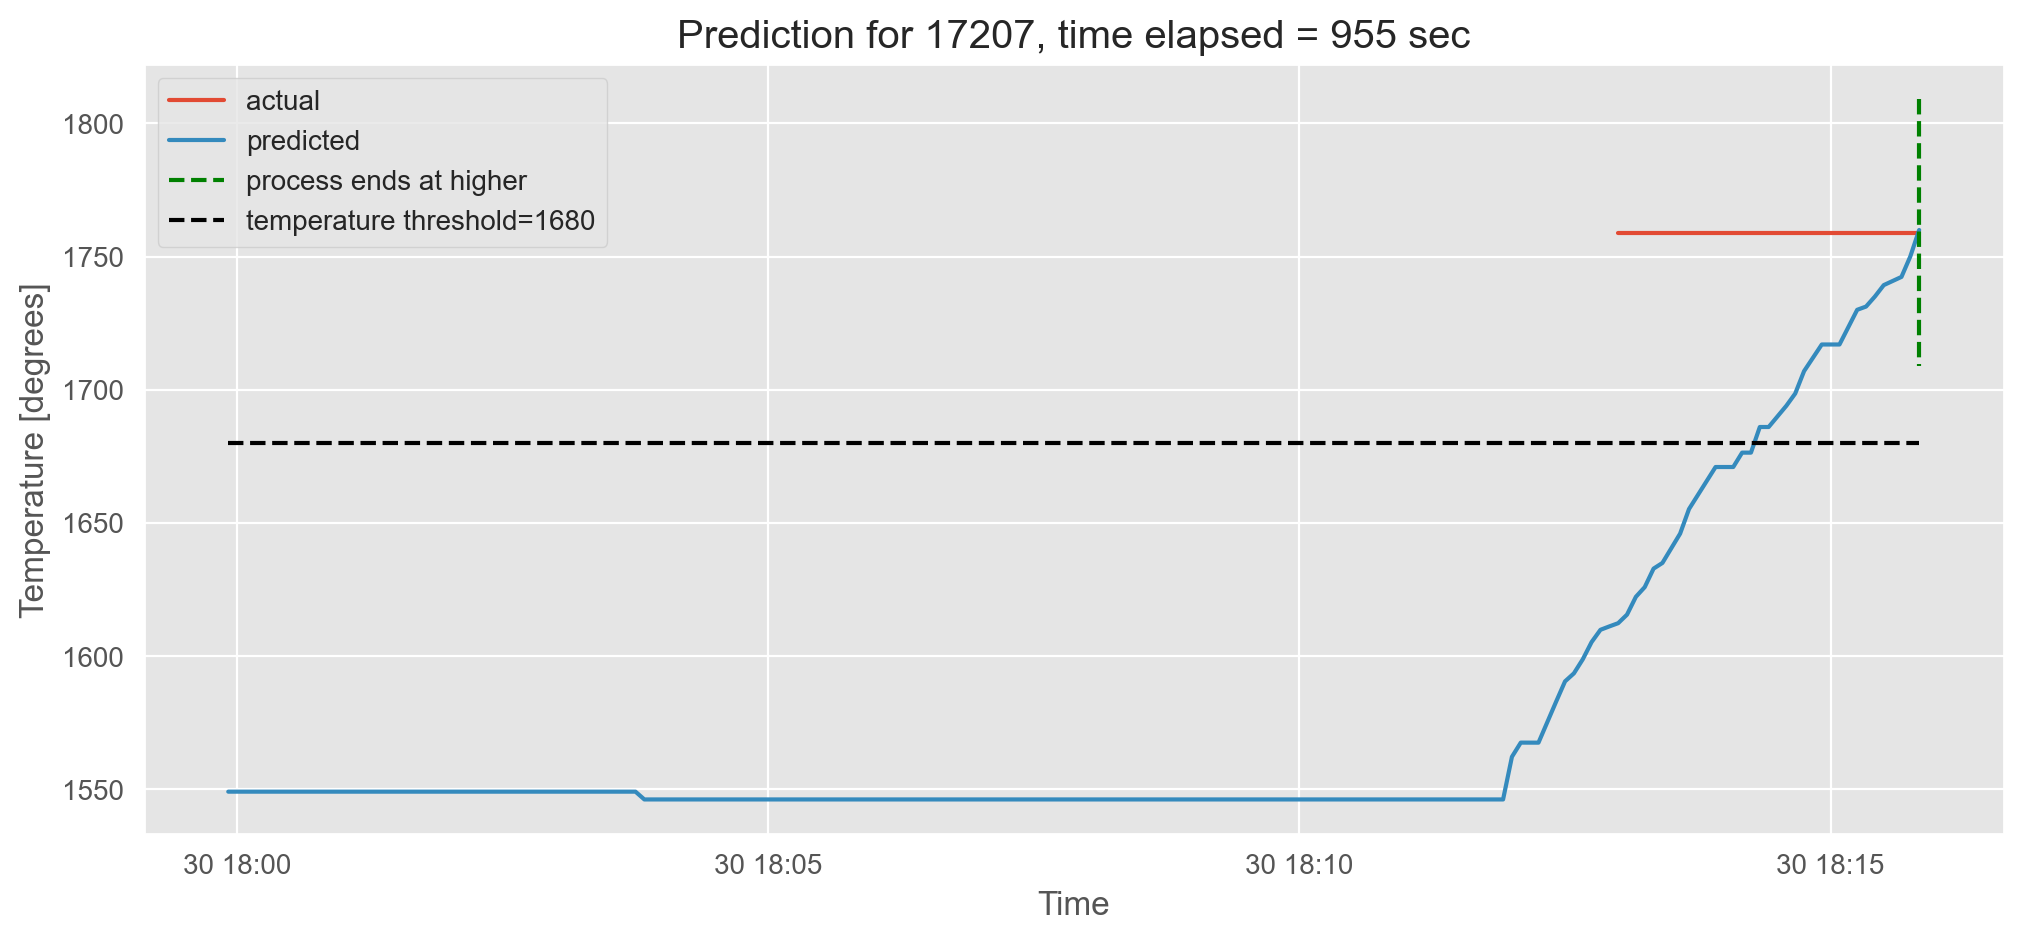

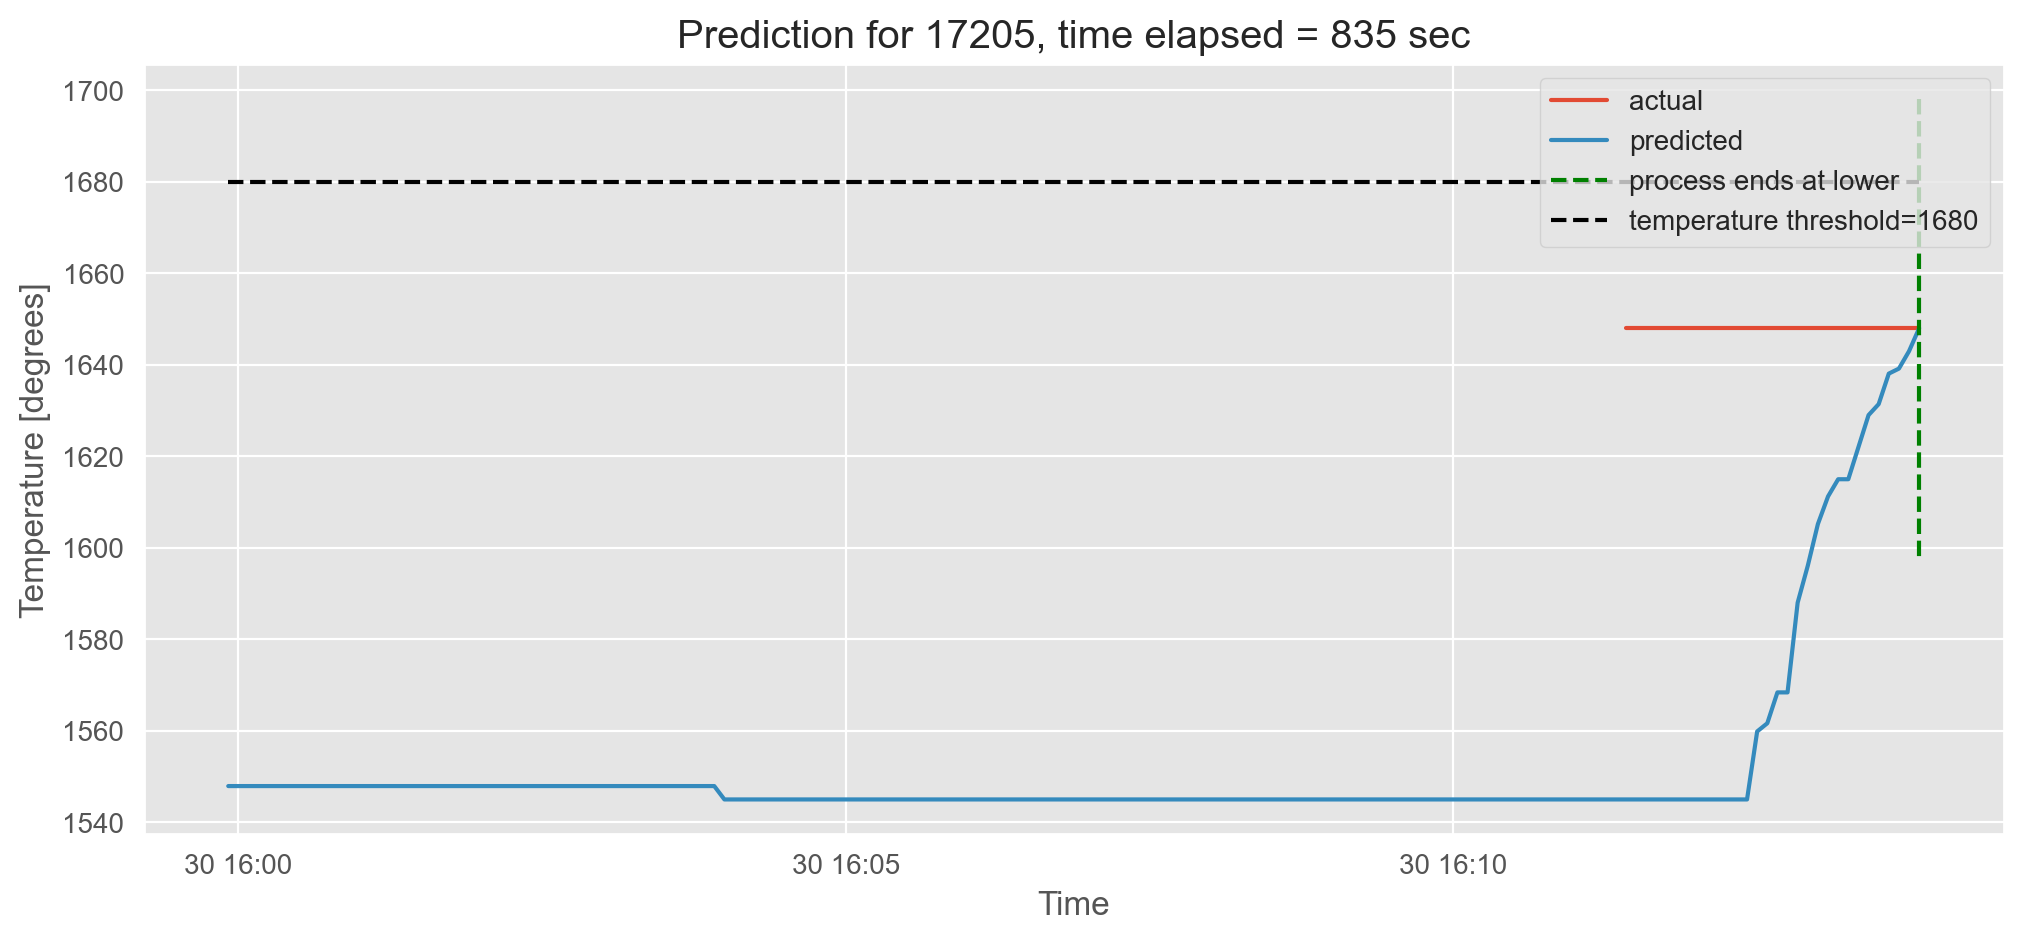

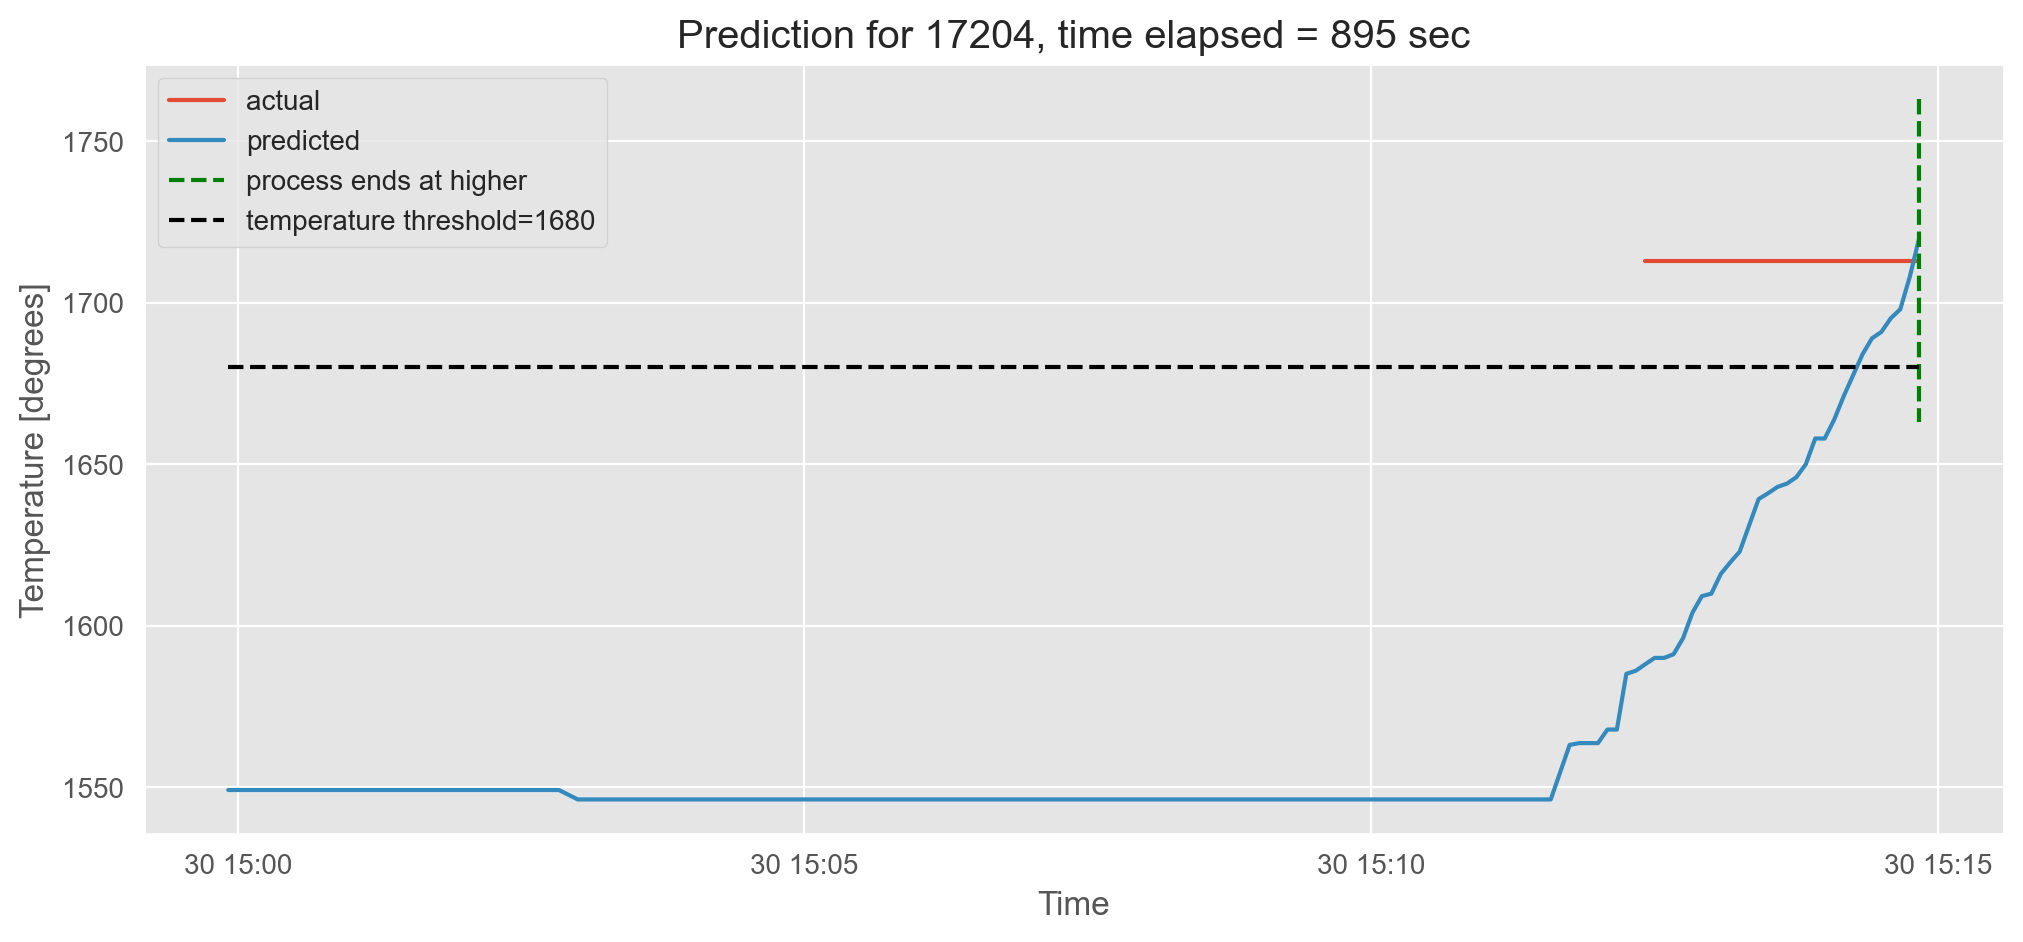

In [226]:
ids = pd.Series(pred_data["heatid"].unique())
_delta = 50
for _id in ids.sample(5, random_state=3):
    plot_data = pred_data.loc[pred_data["heatid"] == _id, ["actual", "pred", "datetime", "status"]]
    plt.figure(figsize=(12, 5))
    plt.plot(plot_data[-30:]["datetime"], plot_data.iloc[-30:]["actual"], label="actual")
    plt.plot(plot_data["datetime"], plot_data["pred"], label="predicted")
    elapsed = pred_data.loc[pred_data["heatid"] == _id, "elapsed"].iloc[-1]
    plt.title(f"Prediction for {_id}, time elapsed = {elapsed:.0f} sec")
    plt.xlabel("Time")
    plt.ylabel("Temperature [degrees]")
    status_row = plot_data.loc[~plot_data["status"].isna(), "datetime"]
    status = plot_data.loc[~plot_data["status"].isna(), "status"].iloc[0]
    plt.vlines(x=plot_data["datetime"].iloc[-1], ymin=plot_data["actual"].min() + _delta,
               ymax=plot_data["actual"].max() - _delta,
               linestyles="--", colors="green", label=f"process ends at {status}")
    plt.hlines(y=TEMP_THRESHOLD, xmin=plot_data["datetime"].min(), xmax=plot_data["datetime"].max(), linestyles="--",
               colors="k", label=f"temperature threshold={TEMP_THRESHOLD}")
    plt.legend()
    plt.show()

# Answers

I think the majority of the tasks/questions were already addressed in this ntb, anyways I explicitly answer them here.

Task 1 [Evaluate data]/ Technical

    Analyze the provided dataset.
    describe concisely, with stats and plots, the core characteristics of the dataset.
    What are extreme values for the gas?

I think the answer is provided by EDA (extreme values of `gas1` can be seen form boxplot in the (#EDA) part) while liner interpolation of `gas1` took place.

---

Task 2 [Manipulate data]/ Technical

Experts have concluded that there is a delay of 5 seconds in measurement of the gas.

    Propose a function to time shift the data.
    [Discussion] Live deployment - see task 5 below: how to store timestamps for different measurements
    in the database? Why?

I would store both values original one and corrected, as at real-time inference the pipeline will query DB. And by simply having already corrected value stored in DB we might reduce query overhead. Next, I can find it's easier for debugging and tracking purposes.
I also introduces some simple [table](../sql/init.sql) where corrected datetime is stored separately.

Task 3: [Modeling]/ Technical + Discussion

    Build a model to estimate the temperature given the gas measurements.
    Provide an analysis of the model quality.
    Describe few model improvements that could benefit the final product.
    How would you use the model in a real-time production scenario?

The baseline with XGB was build, the model was estimated by standard MSE and MAE for single-point data split.
MSE=24.75, MAE=2.34
Furthermore, the asymmetric metric was used during HP optimization.
The further improvements for the model are:
- explore more HP space
- explore more features
- maybe apply some feature selection
- explore and analyze how to use differently asymmetric metric (i.e. different weights)

I'd like to use the model in 2 modes:
1. early warning (long horizon forecasting)
2. later warning (short horizon forecasting)
I would need to experiment more to define some heuristic for clear process stop signal (maybe crossing threshold ± band). Also, I would encorporate 4 opration modes found in the data, i.e. try to solve discrete optimization problem.

Task 4 [Ensuring value]/ Technical + Discussion

    How can you use your model to minimize the restart/overheat losses?
    Justify your proposal with the data.
    (optional) Prepare a simulated experiment using the data and your model.

Basically, I will do such simulations showing how the process is developing and what model is telling.

Task 5 [Deployment] / Discussion

    How would you deploy your model as a recommender system accessible to the operators,
    informing them of the stop time for each batch?

The deployment from my perspective should be done as following:
1. There is a script/cmd which executes HP optimization based daily/ weekly (depends on data drifts and model stability)
2. Then I would perform red/green deployment I think
3. In practice it would be a FastAPI app with v1/v2 predict endpoints corresponding to these red/green deployments.

I also built some very first draft of such an approach.